# PJM Hourly Load Forecasting with TimeXer  

As data scientists, our goal is to move beyond piecemeal pipelines and hand-crafted features toward models that can automatically discover the complex interactions driving PJM load.  In prior work, we explored two common approaches:

1. **XGBoost regressor** on calendar+weather features  
   • Strengths: robust, interpretable splits on engineered inputs (hour, day-of-week, temp, humidity, etc.)  
   • Limitations: requires manual feature design to capture seasonality or lagged dependencies; tree ensembles cannot directly model long-range temporal dynamics.  

2. **ARIMA–LSTM–CNN hybrid**  
   • Strengths: ARIMA isolates and removes linear trend/seasonality; LSTM and CNN layers then learn remaining nonlinear residual patterns.  
   • Limitations: a multi-stage workflow that can be brittle (errors propagate from ARIMA), and sequential networks struggle to attend flexibly across both time steps and parallel exogenous series.

---

**TimeXer** departs from these by treating forecasting as a unified, attention-based sequence modeling problem:

- **Endogenous patching + global token**  
  Rather than feeding raw hourly values into a recurrent network, TimeXer slices the past load series into fixed-length “patches,” embeds each via a learnable linear layer, and prepends a global summary token that aggregates information across all patches.

- **Cross-attention to exogenous features**  
  Weather and calendar embeddings are projected into the same latent space, then attended by the global token—allowing the model to learn, for example, when drops in temperature should outweigh day-of-week effects.

- **Parallel, multi-head self-attention**  
  Unlike LSTMs, transformers process all time steps simultaneously, capturing both short- and long-range dependencies in a single encoder pass. Multiple attention heads let the model learn distinct “views” of the data—e.g. one head might focus on weekly cycles, another on extreme weather events.

- **End-to-end training**  
  The entire network—from patch embedding through cross-attention to the prediction head—is optimized jointly, eliminating the need for separate ARIMA fitting or manual feature splits.  This not only simplifies the pipeline but often yields more accurate, robust short-term forecasts.

**Overview of Workflow:**  
In this notebook, we implement **TimeXer**, a transformer-style model for short-term forecasting of the PJM grid load (PJME). We combine energy consumption data with weather features to improve accuracy, and we’ll walk through:

1. Environment setup and imports  
2. Data loading, cleaning & feature engineering  
3. Train / val / test split & scaling  
4. Model architecture and configuration  
5. Dataset construction & DataLoader  
6. Training with early stopping  
7. Evaluation and visualization  
8. Hyperparameter tuning with Optuna  
9. Final retraining with best parameters  



## 0. Environment Setup & Imports  
Here we import all necessary libraries—standard Python modules, data manipulation tools, plotting libraries, ML utilities, and (optionally) the Meteostat API for weather data. We then configure warning filters, plotting style, and detect GPU availability.


In [ ]:
# -*- coding: utf-8 -*-
# --- Standard Libraries ---
import copy
import time
import warnings
from datetime import datetime, timedelta
import os
import json

# --- Data Manipulation ---
import numpy as np
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar

# --- Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Machine Learning ---
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# --- PyTorch ---
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# --- Weather Data ---
# Ensure meteostat is installed: pip install meteostat
try:
    from meteostat import Stations, Hourly
except ImportError:
    print("Meteostat library not found. Please install it: pip install meteostat")
    # You might want to exit or handle this case appropriately
    # For now, we'll proceed assuming it might be installed later or data is cached
    pass

# --- Configure Warnings and Plot Style ---
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

# --- Check for GPU Availability ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- Helper Functions/Classes ---

def mean_absolute_percentage_error(y_true, y_pred):
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Avoid division by zero
    non_zero_mask = y_true != 0
    # Handle cases where all true values are zero
    if not np.any(non_zero_mask):
        return 0.0
    return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        # *** CORRECTED LINE BELOW ***
        self.val_loss_min = np.inf # Use np.inf instead of np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose: # Only print counter if verbose
                 self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        try:
             torch.save(model.state_dict(), self.path)
        except Exception as e:
             self.trace_func(f"Error saving checkpoint: {e}") # Report errors during saving
        self.val_loss_min = val_loss

# Placeholder for Configs class
class Configs:
    def __init__(self, **kwargs):
        for key, value in kwargs.items():
            setattr(self, key, value)

Using device: cuda


## 1. Data Loading & Feature Engineering  
1. **Load** the PJME hourly load CSV and restrict to our time window.  
2. **Engineer** calendar features (hour, day‐of‐week, holidays, weekends) to capture temporal patterns.  
3. **Fetch** nearby weather station data (temperature, humidity, precipitation, wind) and average across stations for each timestamp.  
4. **Join** energy and weather data, forward/backfill missing values, and verify data integrity.

In [ ]:
csv_path = '../data/3/PJME_hourly.csv'
if not os.path.exists(csv_path):
     print(f"Error: CSV file not found at {csv_path}")
     print("Please download the PJME hourly energy data and place it as PJME_hourly.csv in the current directory.")
     pjme = None # Set to None to prevent further errors if file is missing
else:
    pjme = (
        pd.read_csv(
            csv_path,
            index_col='Datetime',
            parse_dates=['Datetime']
        )
        .sort_index()
        .loc['2003-01-01':'2018-08-02'] # Using the same date range as provided
    )

if pjme is not None:
    # --- Feature Engineering: Holidays and Calendar Features ---
    cal = USFederalHolidayCalendar()
    fed_hols = cal.holidays(start=pjme.index.min(), end=pjme.index.max())

    # Extend July 4th holiday based on weekday
    extended_hols = set(fed_hols)
    for year in range(pjme.index.year.min(), pjme.index.year.max() + 1):
        try:
            july4 = datetime(year, 7, 4)
            wd = july4.weekday()
            if wd == 1:  # If July 4th is a Tuesday, add Monday
                extended_hols.add(july4 - timedelta(days=1))
            elif wd == 2:  # If July 4th is a Wednesday, add Thursday and Friday
                extended_hols.add(july4 + timedelta(days=1))
                extended_hols.add(july4 + timedelta(days=2))
            elif wd == 3:  # If July 4th is a Thursday, add Friday
                extended_hols.add(july4 + timedelta(days=1))
            # Add July 4th itself regardless of the day
            extended_hols.add(july4)
        except ValueError: # Handle cases like leap years if necessary, though July 4th is fixed
             pass

    all_hols = pd.DatetimeIndex(sorted(list(extended_hols))) # Convert set to list before sorting

    pjme['is_holiday'] = pjme.index.normalize().isin(all_hols)
    pjme['is_weekend'] = pjme.index.weekday >= 5
    pjme['is_dayoff'] = (pjme['is_holiday'] | pjme['is_weekend']).astype(int) # Convert boolean to int
    pjme.drop(columns=['is_holiday', 'is_weekend'], inplace=True)

    # Calendar Features
    pjme['hour']       = pjme.index.hour
    pjme['dayofweek']  = pjme.index.dayofweek # Monday=0, Sunday=6
    pjme['dayofmonth'] = pjme.index.day
    pjme['month']      = pjme.index.month
    pjme['year']       = pjme.index.year
    pjme['dayofyear']  = pjme.index.dayofyear
    pjme['weekofyear'] = pjme.index.isocalendar().week.astype(int)


    # --- Fetch and Process Weather Data ---
    # Define date range for weather data (slightly wider to ensure coverage)
    start_dt = pjme.index.min() - timedelta(days=1)
    end_dt   = pjme.index.max() + timedelta(days=1)

    # Coordinates for PJME region center (approximate)
    lat, lon = 39.95, -75.17

    # Target ICAOs based on the original script
    target_icaos = ['KPHL', 'KEWR', 'KBWI', 'KDCA'] # Philadelphia, Newark, Baltimore, Washington DC area airports

    average_weather = None
    try:
        # Find nearby stations (using a reasonable radius, e.g., 200km)
        stations_query = Stations()
        # stations_query = stations_query.nearby(lat, lon, 200000) # 200 km radius
        stations_query = stations_query.inventory('hourly', (start_dt, end_dt))
        nearby_stations_df = stations_query.fetch()

        # Filter for target ICAOs if found, otherwise use closest available
        target_stations_df = nearby_stations_df[nearby_stations_df['icao'].isin(target_icaos)]
        if target_stations_df.empty:
            print(f"Warning: None of the target ICAOs {target_icaos} found nearby or had data. Using the closest available stations.")
            # Optionally, select the top N closest stations if target ones are missing
            station_ids = nearby_stations_df.head(4).index.tolist() # Example: use top 4 closest
        else:
            station_ids = target_stations_df.index.tolist()

        if station_ids:
            print(f"Fetching weather data for stations: {station_ids}")
            # Fetch hourly data
            weather_all = Hourly(station_ids, start_dt, end_dt).fetch()

            # Select relevant weather columns and calculate average
            weather_cols = ['temp', 'dwpt', 'rhum', 'prcp', 'wspd'] # Temperature (°C), Dew Point (°C), Relative Humidity (%), Precipitation (mm), Wind Speed (km/h)
            # Ensure only selected columns exist before grouping
            valid_cols = [col for col in weather_cols if col in weather_all.columns]
            average_weather = weather_all.groupby(level='time').mean(numeric_only=True)[valid_cols].ffill().bfill() # Forward fill then backfill
            print("Weather data fetched and processed.")
        else:
            print("Warning: No suitable weather stations found.")

    except Exception as e:
        print(f"An error occurred during weather data fetching: {e}")
        print("Proceeding without weather data.")

    # --- Combine Energy and Weather Data ---
    if average_weather is not None:
        pjme_weather = pjme.join(average_weather, how='left')
        # Fill missing weather data (e.g., at the beginning/end or if fetching failed partially)
        # Using forward fill first, then backward fill
        pjme_weather[average_weather.columns] = pjme_weather[average_weather.columns].ffill().bfill()
        print("Energy and weather data joined.")
    else:
        pjme_weather = pjme.copy()
        # Add placeholder columns if weather data is missing
        weather_cols = ['temp', 'dwpt', 'rhum', 'prcp', 'wspd']
        for col in weather_cols:
            if col not in pjme_weather.columns:
                 pjme_weather[col] = 0 # Or another suitable default
        print("Proceeding with energy data only.")


    # Ensure no NaNs remain after joins and fills
    # Check for NaNs and report if any
    nan_counts = pjme_weather.isna().sum()
    if nan_counts.sum() > 0:
        print("Warning: NaNs found after processing:")
        print(nan_counts[nan_counts > 0])
        # Option 1: Drop rows with NaNs (might lose data)
        # pjme_weather.dropna(inplace=True)
        # Option 2: Fill with a specific value (like 0 or mean) - already tried ffill/bfill
        # Consider more sophisticated imputation if necessary
        print("Attempting final fill with 0 for any remaining NaNs...")
        pjme_weather.fillna(0, inplace=True)


    print(f'Combined data shape: {pjme_weather.shape}')
    # Check index monotonicity again
    pjme_weather = pjme_weather.sort_index()
    print(f'Index monotonic? {pjme_weather.index.is_monotonic_increasing}')
    print("Data Head:")
    print(pjme_weather.head())
    print("\nData Tail:")
    print(pjme_weather.tail())
    print("\nData Info:")
    pjme_weather.info()
    print("\nNaN check after processing:")
    print(pjme_weather.isna().sum())


    # --- Define Target and Features ---
    TARGET = 'PJME_MW'
    # Features = All columns except the target
    FEATURES = [col for col in pjme_weather.columns if col != TARGET]
    print(f"\nTarget variable: {TARGET}")
    print(f"Feature columns: {FEATURES}")
    print(f"Number of features: {len(FEATURES)}")

else:
    print("Execution stopped due to missing data file.")

Fetching weather data for stations: ['72405', '72406', '72408', '72502']
Weather data fetched and processed.
Energy and weather data joined.
Combined data shape: (136608, 14)
Index monotonic? True
Data Head:
                     PJME_MW  is_dayoff  hour  dayofweek  dayofmonth  month  \
2003-01-01 00:00:00  27008.0          1     0          2           1      1   
2003-01-01 01:00:00  25591.0          1     1          2           1      1   
2003-01-01 02:00:00  24235.0          1     2          2           1      1   
2003-01-01 03:00:00  23121.0          1     3          2           1      1   
2003-01-01 04:00:00  22445.0          1     4          2           1      1   

                     year  dayofyear  weekofyear   temp   dwpt   rhum  prcp  \
2003-01-01 00:00:00  2003          1           1  9.450  4.675  73.25   0.0   
2003-01-01 01:00:00  2003          1           1  9.300  4.750  74.00   0.0   
2003-01-01 02:00:00  2003          1           1  7.800  4.400  79.25   0.0   
2

## 2. Train / Validation / Test Split  
We split chronologically to avoid leakage:  
- 80 % for training  
- 10 % for validation  
- 10 % for testing  

We also plot the PJM load time series colored by split to visually confirm the partition.

Train: 109286 rows (2003-01-01 00:00:00 to 2015-06-21 13:00:00)
Val  : 13661 rows (2015-06-21 14:00:00 to 2017-01-10 17:00:00)
Test : 13661 rows (2017-01-10 18:00:00 to 2018-08-02 23:00:00)


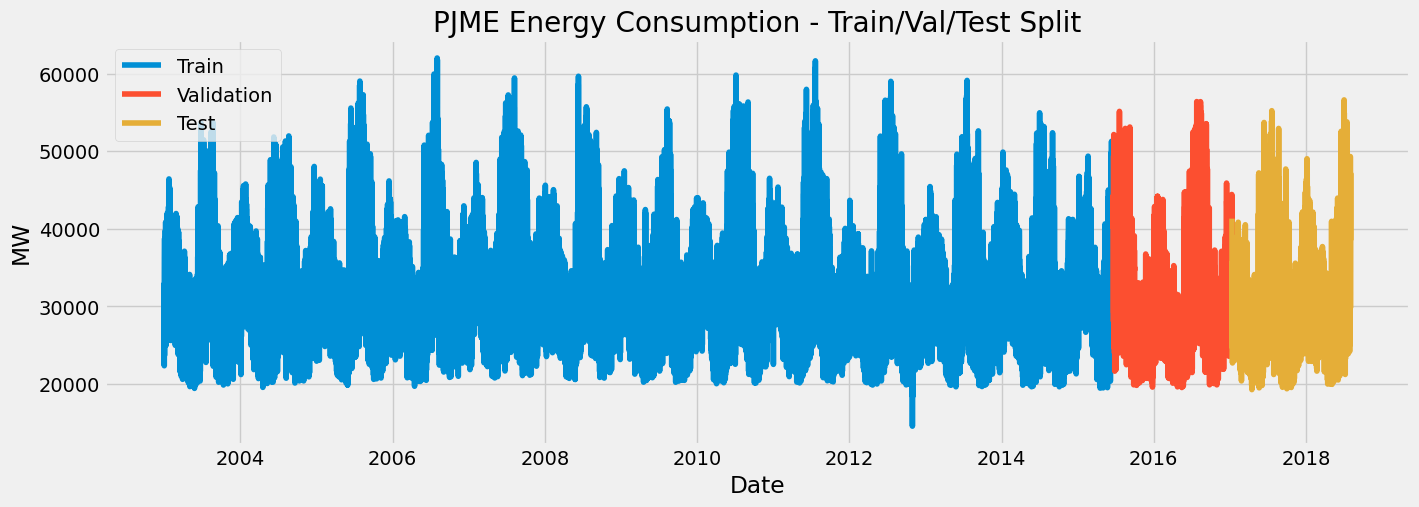

In [3]:
if pjme_weather is not None:
    total_hours = len(pjme_weather)
    # Using the same 80/10/10 split ratios
    test_split_idx = int(total_hours * 0.9)
    val_split_idx = int(total_hours * 0.8)

    train_df = pjme_weather.iloc[:val_split_idx].copy()
    val_df = pjme_weather.iloc[val_split_idx:test_split_idx].copy()
    test_df = pjme_weather.iloc[test_split_idx:].copy()

    print(f"Train: {len(train_df)} rows ({train_df.index.min()} to {train_df.index.max()})")
    print(f"Val  : {len(val_df)} rows ({val_df.index.min()} to {val_df.index.max()})")
    print(f"Test : {len(test_df)} rows ({test_df.index.min()} to {test_df.index.max()})")

    # Visualize the split
    plt.figure(figsize=(15, 5))
    plt.plot(train_df.index, train_df[TARGET], label='Train')
    plt.plot(val_df.index, val_df[TARGET], label='Validation')
    plt.plot(test_df.index, test_df[TARGET], label='Test')
    plt.title('PJME Energy Consumption - Train/Val/Test Split')
    plt.xlabel('Date')
    plt.ylabel('MW')
    plt.legend()
    plt.show()
else:
     print("Skipping split due to missing data.")

## 3. Data Scaling  
We apply **StandardScaler** separately to features and the target so that our model trains more stably.  
- Fit on the train set  
- Transform train, val, and test  
- Keep target scaler for later inverse‐transform


In [4]:
if pjme_weather is not None:
    # Scale features (exogenous variables)
    feature_scaler = StandardScaler()
    train_df[FEATURES] = feature_scaler.fit_transform(train_df[FEATURES])
    val_df[FEATURES] = feature_scaler.transform(val_df[FEATURES])
    test_df[FEATURES] = feature_scaler.transform(test_df[FEATURES])

    # Scale target variable separately (important for inverse transform later)
    target_scaler = StandardScaler()
    train_df[[TARGET]] = target_scaler.fit_transform(train_df[[TARGET]])
    val_df[[TARGET]] = target_scaler.transform(val_df[[TARGET]])
    test_df[[TARGET]] = target_scaler.transform(test_df[[TARGET]])

    print("Features and target variable scaled.")
    print("Train DataFrame head after scaling:")
    print(train_df.head())
else:
     print("Skipping scaling due to missing data.")

Features and target variable scaled.
Train DataFrame head after scaling:
                      PJME_MW  is_dayoff      hour  dayofweek  dayofmonth  \
2003-01-01 00:00:00 -0.830722   1.477475 -1.661665  -0.500253   -1.672229   
2003-01-01 01:00:00 -1.051358   1.477475 -1.517189  -0.500253   -1.672229   
2003-01-01 02:00:00 -1.262495   1.477475 -1.372713  -0.500253   -1.672229   
2003-01-01 03:00:00 -1.435951   1.477475 -1.228238  -0.500253   -1.672229   
2003-01-01 04:00:00 -1.541209   1.477475 -1.083762  -0.500253   -1.672229   

                        month      year  dayofyear  weekofyear      temp  \
2003-01-01 00:00:00 -1.566074 -1.593315  -1.691714   -1.665309 -0.405299   
2003-01-01 01:00:00 -1.566074 -1.593315  -1.691714   -1.665309 -0.420108   
2003-01-01 02:00:00 -1.566074 -1.593315  -1.691714   -1.665309 -0.568199   
2003-01-01 03:00:00 -1.566074 -1.593315  -1.691714   -1.665309 -0.570667   
2003-01-01 04:00:00 -1.566074 -1.593315  -1.691714   -1.665309 -0.612627   

       

## 4. Model Building Blocks  

1. **PositionalEmbedding**  
   - **Role**: Injects information about token position (i.e. time step) into the model, so it can distinguish “first hour” from “tenth hour.”  
   - **Key points**:  
     - Precomputes a fixed `(max_len × d_model)` matrix of sine/cosine values in log space.  
     - No trainable weights—just a registered buffer.  
     - On `forward(x)`, slices out the first `seq_len` rows, returning a `[seq_len, d_model]` tensor that’s broadcast across the batch.  
     - Guards against sequence lengths exceeding `max_len`.  

2. **TimeFeatureEmbedding**  
   - **Role**: Projects raw calendar/time‐of‐day features into the model’s embedding dimension.  
   - **Key points**:  
     - For hourly data (`freq='h'`), expects 6 inputs:  
       1. hour of day  
       2. day of week  
       3. day of month  
       4. day of year  
       5. month  
       6. ISO week of year  
     - Implements a single linear layer: `nn.Linear(d_inp=6, d_model, bias=False)`.  
     - `forward(x)` simply applies that projection to each time step.  

3. **TokenEmbedding**  
   - **Role**: Embeds the numeric values of each feature vector (exogenous or endogenous) into `d_model` dimensions.  
   - **Key points**:  
     - Uses `self.value_embedding = nn.Linear(c_in, d_model)`.  
     - On `forward(x)`, maps `[batch, seq_len, c_in] → [batch, seq_len, d_model]`.  
     - (Commented-out Conv1d alternative hints at other possible architectures.)  

4. **FullAttention**  
   - **Role**: Implements scaled-dot-product attention with optional masking and dropout.  
   - **Key points**:  
     - Computes raw scores via `torch.einsum("blhe,bshe->bhls", queries, keys)`.  
     - Applies mask (if `mask_flag=True`) to prevent attending to future/padded tokens.  
     - Scales by `1/√E` (or a user-provided `scale`), then applies `softmax` + `Dropout`.  
     - Returns the attended output of shape `[batch, seq_len, H*E]`, plus the attention map if `output_attention=True`.  

5. **AttentionLayer**  
   - **Role**: Wraps a `FullAttention` module to handle multi-head projections and output reshaping.  
   - **Key points**:  
     - Contains three linear layers to project the input into query/key/value spaces:  
       - `query_projection`: `d_model → n_heads × d_keys`  
       - `key_projection`, `value_projection` similarly.  
     - Calls `self.inner_attention`, then concatenates the `H` heads and applies `self.out_projection` back to `d_model`.  
     - Ensures seamless integration of multi-head attention into the Transformer.  

6. **EarlyStopping**  
   - **Role**: Monitors validation loss and halts training (and restores the best checkpoint) once no improvement is seen for `patience` epochs.  
   - **Key points**:  
     - Tracks the best validation loss (`val_loss_min`) and a counter of unimproved epochs.  
     - On each `__call__(val_loss, model)`:  
       - If loss improved by at least `delta`, saves a new checkpoint via `torch.save(model.state_dict(), path)` and resets `counter`.  
       - Otherwise increments `counter` and, if ≥ `patience`, sets `early_stop=True`.  
     - Optional verbose logging to trace when checkpoints are saved or early stopping is triggered.  

Together, these building blocks—embeddings for time, value, and position, plus the core attention mechanics and a training‐time safeguard—form the foundation of TimeXer’s transformer‐style encoder and downstream prediction head.

In [5]:
# --- Positional Embedding ---
class PositionalEmbedding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEmbedding, self).__init__()
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model).float()
        pe.require_grad = False

        position = torch.arange(0, max_len).float().unsqueeze(1)
        div_term = (torch.arange(0, d_model, 2).float() * -(np.log(10000.0) / d_model)).exp()

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        # Keep pe shape as [max_len, d_model] for easier slicing
        # pe = pe.unsqueeze(0) # Remove batch dim here
        self.register_buffer('pe', pe)

    def forward(self, x):
        # Input x shape: Tensor for which we need positional embedding, used to determine seq_len
        # Output shape: [seq_len, d_model] - The calling function will handle batch expansion
        seq_len = x.size(1) # Assuming x has shape [B, L, D] or similar where L is seq_len
        if seq_len > self.pe.size(0):
             raise ValueError(f"Sequence length {seq_len} exceeds maximum positional embedding length {self.pe.size(0)}")
        # Return the slice corresponding to the sequence length
        return self.pe[:seq_len, :]


# --- Time Feature Embedding (Part of DataEmbedding_inverted) ---
class TimeFeatureEmbedding(nn.Module):
    def __init__(self, d_model, embed_type='timeF', freq='h'):
        super(TimeFeatureEmbedding, self).__init__()

        # Determine input dimension based on frequency
        # Adjust based on the actual features computed in TimeSeriesDataset._compute_time_features
        # Current features: hour, dayofweek, day, dayofyear, month, weekofyear -> 6 features
        if freq == 'h':
            # Match the number of features created in the Dataset class
            d_inp = 6 # hour, dayofweek, dayofmonth, dayofyear, month, weekofyear
        # Add other frequencies if needed
        # elif freq == 't': d_inp = ...
        else:
            d_inp = 2 # Default fallback
        self.embed = nn.Linear(d_inp, d_model, bias=False)

    def forward(self, x):
        # x shape: [Batch, SeqLen, NumTimeFeatures]
        return self.embed(x) # Output: [Batch, SeqLen, d_model]

# --- Value Embedding (Part of DataEmbedding_inverted) ---
# Simple Linear layer for value embedding
class TokenEmbedding(nn.Module):
    def __init__(self, c_in, d_model):
        super(TokenEmbedding, self).__init__()
        padding = 1 if torch.__version__ >= '1.5.0' else 2
        # Use Linear layer for value embedding per feature, seems more common than Conv1d here
        # self.tokenConv = nn.Conv1d(in_channels=c_in, out_channels=d_model,
        #                            kernel_size=3, padding=padding, padding_mode='circular', bias=False)
        self.value_embedding = nn.Linear(c_in, d_model) # Embeds features directly

        # Initialize weights
        # for m in self.modules():
        #     if isinstance(m, nn.Conv1d):
        #         nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu')

    def forward(self, x):
        # x shape: [Batch, SeqLen, Features]
        # x = self.tokenConv(x.permute(0, 2, 1)).transpose(1, 2) # If using Conv1d
        x = self.value_embedding(x) # Using Linear
        return x # Shape: [Batch, SeqLen, d_model]


# --- Data Embedding (Combined - Simplified version of DataEmbedding_inverted) ---
# This embedding is used for the *exogenous* variables in TimeXer
class DataEmbeddingExog(nn.Module):
    def __init__(self, c_in_exog, c_in_time, d_model, embed_type='timeF', freq='h', dropout=0.1):
        super(DataEmbeddingExog, self).__init__()

        # Embeds the exogenous variable values
        self.value_embedding = TokenEmbedding(c_in=c_in_exog, d_model=d_model)
        # Embeds the time features (like hour, dayofweek)
        self.temporal_embedding = TimeFeatureEmbedding(d_model=d_model, embed_type=embed_type, freq=freq)
        # Positional embedding (sinusoidal) - Added here for consistency
        self.position_embedding = PositionalEmbedding(d_model=d_model)

        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, x_mark):
        # x: Exogenous variable values [Batch, SeqLen, NumExogVars (c_in_exog)]
        # x_mark: Time features [Batch, SeqLen, NumTimeFeatures (c_in_time)]

        # Get positional encoding slice [SeqLen, d_model]
        # Need to pass a tensor with correct seq_len dimension (dim 1)
        pos_enc_slice = self.position_embedding(x) # Pass x to get seq_len

        # Apply embeddings and add them
        # Expand pos_enc_slice to [Batch, SeqLen, d_model] for addition
        x = self.value_embedding(x) + self.temporal_embedding(x_mark) + pos_enc_slice.unsqueeze(0).expand(x.shape[0], -1, -1)

        return self.dropout(x) # Shape: [Batch, SeqLen, d_model]


# --- Attention Layers (Standard Implementation -UNCHANGED from previous version) ---
class FullAttention(nn.Module):
    def __init__(self, mask_flag=True, factor=5, scale=None, attention_dropout=0.1, output_attention=False):
        super(FullAttention, self).__init__()
        self.scale = scale
        self.mask_flag = mask_flag
        self.output_attention = output_attention
        self.dropout = nn.Dropout(attention_dropout)

    def forward(self, queries, keys, values, attn_mask, tau=None, delta=None):
        B, L, H, E = queries.shape
        _, S, _, D = values.shape
        scale = self.scale or 1. / np.sqrt(E)

        scores = torch.einsum("blhe,bshe->bhls", queries, keys)

        if self.mask_flag and attn_mask is not None:
            # Ensure attn_mask is broadcastable
            if attn_mask.dim() == 2: # [L, S]
                attn_mask = attn_mask.unsqueeze(0).unsqueeze(0) # [1, 1, L, S]
            elif attn_mask.dim() == 3: # [B, L, S]
                 attn_mask = attn_mask.unsqueeze(1) # [B, 1, L, S]
            scores = scores.masked_fill(attn_mask == 0, -float('inf')) # Use float('-inf')


        A = self.dropout(torch.softmax(scores * scale, dim=-1))
        V = torch.einsum("bhls,bshe->blhe", A, values).contiguous() # Use contiguous here

        if self.output_attention:
            return (V.view(B, L, -1), A) # Reshape V back
        else:
            return (V.view(B, L, -1), None) # Reshape V back


class AttentionLayer(nn.Module):
    def __init__(self, attention, d_model, n_heads, d_keys=None, d_values=None):
        super(AttentionLayer, self).__init__()

        d_keys = d_keys or (d_model // n_heads)
        d_values = d_values or (d_model // n_heads)

        self.inner_attention = attention
        self.query_projection = nn.Linear(d_model, d_keys * n_heads)
        self.key_projection = nn.Linear(d_model, d_keys * n_heads)
        self.value_projection = nn.Linear(d_model, d_values * n_heads)
        self.out_projection = nn.Linear(d_values * n_heads, d_model)
        self.n_heads = n_heads

    def forward(self, queries, keys, values, attn_mask, tau=None, delta=None):
        B, L, _ = queries.shape
        _, S, _ = keys.shape
        H = self.n_heads

        # Project queries, keys, values
        queries = self.query_projection(queries).view(B, L, H, -1)
        keys = self.key_projection(keys).view(B, S, H, -1)
        values = self.value_projection(values).view(B, S, H, -1)

        # Apply attention mechanism
        out, attn = self.inner_attention(
            queries,
            keys,
            values,
            attn_mask,
            tau=tau, delta=delta
        )
        # Concatenate heads and apply final projection
        out = self.out_projection(out) # Shape [B, L, d_model]
        return out, attn

## 5. TimeXer Model Definition  

1. **EnEmbedding (Endogenous Embedding)**  
   - **Role**: Converts the historical target series into a sequence of patch tokens plus a learnable “global” summary token, so the model can attend both locally (within each patch) and globally (across the entire history).  
   - **Key points**:  
     - **Patching**: The input series is split into fixed-length windows (patches). Each patch is linearly projected into the model dimension.  
     - **Global token**: A dedicated, trainable vector is prepended (or appended) to the patch tokens, allowing the encoder to gather summary information.  
     - **Positional encoding**: Sinusoidal embeddings are added so the model knows each patch’s relative position in time.  
     - **Output shape**: Flattens to `[batch_size × n_vars, num_patches+1, d_model]` for downstream attention layers.  

2. **DataEmbeddingExog (Exogenous Embedding)**  
   - **Role**: Embeds the auxiliary inputs (weather, calendar flags, etc.) both as raw values and as time features, then combines them into a unified token sequence for cross‐attention.  
   - **Key points**:  
     - **Value embedding**: A linear layer maps each exogenous feature vector at a given time step into `d_model` dimensions.  
     - **Time feature embedding**: The same calendar features used elsewhere (hour, day-of-week, etc.) are projected into `d_model` and added.  
     - **Positional encoding**: Sinusoidal embeddings ensure the model can distinguish the ordering of exogenous steps.  
     - **Dropout**: Applied after summing all embeddings to regularize.  
     - **Result**: Produces a `[batch_size, seq_len, d_model]` tensor that will serve as key/value tokens in cross-attention.  

3. **Encoder (Stacked Transformer Layers with Cross-Attention)**  
   - **Role**: Iteratively refines the endogenous patch+global tokens by attending to themselves (self-attention) and then letting the global token query the exogenous token set (cross-attention).  
   - **Key points**:  
     - **Self-attention block**: Each layer first applies multi-head attention over the patch+global sequence, capturing intra-series dependencies.  
     - **Cross-attention block**: The **global token** only attends to the exogenous embeddings (keys/values), allowing the model to inject weather/calendar context into the global summary.  
     - **Feed-forward network**: A two-stage 1×1 convolution (i.e. position-wise feed-forward) with residual connections and LayerNorm after each sub-block.  
     - **Layer stacking**: Multiple identical layers are chained, followed by a final normalization.  

4. **FlattenHead (Prediction Head)**  
   - **Role**: Takes the final patch+global representations and collapses them into a fixed-size forecast window (e.g. next 24 hours).  
   - **Key points**:  
     - **Flattening**: The last layer’s output is reshaped so that each token dimension and patch dimension form a single feature vector per variable.  
     - **Linear mapping**: A fully connected layer projects this flattened vector to the desired `pred_len`.  
     - **Dropout**: Applied before output to prevent overfitting.  
     - **Output shape**: Produces `[batch_size, n_vars, pred_len]`, which for a univariate target reduces to `[batch_size, pred_len, 1]`.  

In [6]:
class FlattenHead(nn.Module):
    def __init__(self, n_vars, nf, target_window, head_dropout=0):
        super().__init__()
        self.n_vars = n_vars
        self.flatten = nn.Flatten(start_dim=-2) # Flattens d_model and patch_num dimensions
        self.linear = nn.Linear(nf, target_window)
        self.dropout = nn.Dropout(head_dropout)

    def forward(self, x):  # x: [bs, nvars, d_model, patch_num]
        # Flatten along dimensions d_model and patch_num
        # Input shape to flatten: [bs * nvars, d_model, patch_num] (if reshaped before)
        # Or handle [bs, nvars, d_model, patch_num] directly
        # Let's assume input x is [bs, nvars, d_model, patch_num] based on comment

        # Flatten d_model and patch_num dims. Input is [bs, nvars, d_model, patch_num]
        # Result shape: [bs, nvars, d_model * patch_num]
        x = self.flatten(x)

        # Apply linear layer. Input is [bs, nvars, nf (=d_model*patch_num)]
        # Output shape: [bs, nvars, target_window]
        x = self.linear(x)
        x = self.dropout(x)
        return x


class EnEmbedding(nn.Module):
    """
    Embedding for Endogenous variable(s).
    Applies patching, value embedding, positional embedding, and adds a global token.
    *** CORRECTED Positional Embedding Handling ***
    """
    def __init__(self, n_vars, d_model, patch_len, dropout):
        super(EnEmbedding, self).__init__()
        self.patch_len = patch_len
        self.n_vars = n_vars
        self.d_model = d_model

        # Linear layer to embed each patch
        self.value_embedding = nn.Linear(patch_len, d_model, bias=False)
        # Learnable global token (one per endogenous variable)
        self.glb_token = nn.Parameter(torch.randn(1, n_vars, 1, d_model))
        # Positional embedding for patches
        self.position_embedding = PositionalEmbedding(d_model) # Instantiate corrected PositionalEmbedding
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Input x shape: [batch_size, seq_len, n_vars] -> expecting n_vars=1 based on paper for univariate endogenous
        # Transpose to [batch_size, n_vars, seq_len] for unfolding
        x = x.permute(0, 2, 1)
        batch_size, n_vars_in, seq_len = x.shape
        assert n_vars_in == self.n_vars, f"Input n_vars ({n_vars_in}) doesn't match model n_vars ({self.n_vars})"

        # Patching using unfold
        x_unfolded = x.unfold(dimension=-1, size=self.patch_len, step=self.patch_len)
        num_patches = x_unfolded.shape[2] # Shape after unfold: [batch_size, n_vars, num_patches, patch_len]

        # Reshape for linear embedding: [batch_size * n_vars * num_patches, patch_len]
        x_reshaped = x_unfolded.permute(0, 1, 2, 3).reshape(-1, self.patch_len)

        # Apply value embedding
        x_embedded = self.value_embedding(x_reshaped) # Shape: [batch_size * n_vars * num_patches, d_model]

        # Reshape back to [batch_size, n_vars, num_patches, d_model]
        x_embedded = x_embedded.reshape(batch_size, n_vars_in, num_patches, self.d_model)

        # --- Get and Add Positional Embedding ---
        # Get positional encoding slice [num_patches, d_model]
        # Pass a dummy tensor with correct seq_len (num_patches) to positional embedding
        dummy_pos_input = torch.zeros(1, num_patches, self.d_model, device=x.device)
        pos_encoding_slice = self.position_embedding(dummy_pos_input) # Shape: [num_patches, d_model]

        # Expand slice and add to x_embedded
        # Expand to [batch_size, n_vars, num_patches, d_model]
        pos_embed = pos_encoding_slice.unsqueeze(0).unsqueeze(0).expand(batch_size, n_vars_in, -1, -1)
        x_patched_embedded = x_embedded + pos_embed # Add positional embedding

        # Prepare global token: repeat for batch and concatenate
        glb = self.glb_token.repeat((batch_size, 1, 1, 1)) # Shape: [batch_size, n_vars, 1, d_model]

        # Concatenate global token with patch tokens along the sequence (num_patches) dimension
        x_with_glb = torch.cat([x_patched_embedded, glb], dim=2) # Shape: [batch_size, n_vars, num_patches + 1, d_model]

        # Reshape for Transformer layers: [batch_size * n_vars, num_patches + 1, d_model]
        x_final = x_with_glb.reshape(batch_size * n_vars_in, num_patches + 1, self.d_model)

        return self.dropout(x_final), n_vars_in # Return reshaped tokens and original number of variables


class Encoder(nn.Module):
    def __init__(self, layers, norm_layer=None):
        super(Encoder, self).__init__()
        self.layers = nn.ModuleList(layers)
        self.norm = norm_layer

    def forward(self, x, cross, x_mask=None, cross_mask=None, tau=None, delta=None):
        # x: Endogenous tokens [B*n_vars_en, N+1, D]
        # cross: Exogenous tokens [B, C, D] or potentially [B, SeqLen_exog, D] if using DataEmbeddingExog output
        for layer in self.layers:
            x = layer(x, cross, x_mask=x_mask, cross_mask=cross_mask, tau=tau, delta=delta)

        if self.norm is not None:
            x = self.norm(x)

        return x


class EncoderLayer(nn.Module):
    def __init__(self, self_attention, cross_attention, d_model, n_vars_en, c_exog, d_ff=None,
                 dropout=0.1, activation="relu"):
        super(EncoderLayer, self).__init__()
        d_ff = d_ff or 4 * d_model
        self.n_vars_en = n_vars_en # Number of endogenous variables
        self.c_exog = c_exog # Number of exogenous variables

        self.self_attention = self_attention # Attends over endogenous patches + global token
        self.cross_attention = cross_attention # Attends global token (query) to exogenous variate tokens (key/value)

        self.conv1 = nn.Conv1d(in_channels=d_model, out_channels=d_ff, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=d_ff, out_channels=d_model, kernel_size=1)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        self.activation = F.relu if activation == "relu" else F.gelu

    def forward(self, x, cross, x_mask=None, cross_mask=None, tau=None, delta=None):
        # x: Endogenous tokens (Patch + Global) [Batch * n_vars_en, N+1, D]
        # cross: Exogenous tokens [Batch, C, D] or [Batch, SeqLen_exog, D]

        # --- Self-Attention over Endogenous Tokens (Patches + Global) ---
        x_res = x # Store residual connection input
        x_attn, _ = self.self_attention(
            x, x, x,
            attn_mask=x_mask,
            tau=tau, delta=None
        )
        x = x_res + self.dropout(x_attn) # Add residual
        x = self.norm1(x)
        # x shape: [B * n_vars_en, N+1, D]

        # Store output for later FFN residual connection
        x_after_self_attn = x

        # --- Cross-Attention: Endogenous Global Token <-> Exogenous Tokens ---
        x_glb_en = x[:, -1, :] # Get current global token (output of norm1)
        x_glb_en_query = x_glb_en.unsqueeze(1) # Shape: [B*n_vars_en, 1, D]

        # Prepare exogenous 'cross' input
        batch_size_x = x.shape[0]
        batch_size_cross = cross.shape[0]

        if batch_size_x != batch_size_cross:
             if batch_size_x == batch_size_cross * self.n_vars_en:
                 cross_repeated = cross.repeat_interleave(self.n_vars_en, dim=0)
             else:
                  raise ValueError("Batch size mismatch between endogenous and exogenous tokens.")
        else:
             cross_repeated = cross

        # Apply cross-attention
        x_glb_attn, _ = self.cross_attention(
            x_glb_en_query, cross_repeated, cross_repeated,
            attn_mask=cross_mask,
            tau=tau, delta=delta
        ) # Shape: [B*n_vars_en, 1, D]

        # Add result back to original global token (residual connection for cross-attention)
        x_glb_updated = x_glb_en + self.dropout(x_glb_attn.squeeze(1)) # Remove seq dim 1
        x_glb_updated = self.norm2(x_glb_updated) # Shape: [B*n_vars_en, D]


        # --- Combine Patches and Updated Global Token ---
        # *** CORRECTION: Avoid inplace modification ***
        x_patches = x_after_self_attn[:, :-1, :] # Get patch tokens [B*n_vars_en, N, D]
        x_glb_updated_unsqueezed = x_glb_updated.unsqueeze(1) # Shape [B*n_vars_en, 1, D]
        # Create the new tensor 'x' for the FFN input
        x_ffn_input = torch.cat([x_patches, x_glb_updated_unsqueezed], dim=1) # Shape [B*n_vars_en, N+1, D]


        # --- Feed Forward Network ---
        # Apply FFN to the combined tensor
        y = x_ffn_input
        y = self.dropout(self.activation(self.conv1(y.transpose(-1, 1)))) # [B*n_vars_en, d_ff, N+1]
        y = self.dropout(self.conv2(y).transpose(-1, 1)) # [B*n_vars_en, N+1, d_model]

        # Final residual connection and norm
        return self.norm3(x_ffn_input + y) # Add residual from *before* FFN
    

class Model(nn.Module):
    """
    TimeXer Model for Forecasting with Exogenous Variables.
    """
    def __init__(self, configs):
        super(Model, self).__init__()
        self.task_name = configs.task_name
        self.features = configs.features # 'M' (multivariate) or 'S' (univariate target) or 'MS' (multi-variate input, single target)
        self.seq_len = configs.seq_len
        self.pred_len = configs.pred_len
        self.use_norm = configs.use_norm # Instance Normalization
        self.patch_len = configs.patch_len
        self.patch_num = int(np.ceil(configs.seq_len / configs.patch_len)) # Use ceil for potential last partial patch
        self.d_model = configs.d_model

        # Determine number of endogenous and exogenous variables based on 'features' config
        if self.features == 'S': # Univariate target, no exogenous in input tensor `x_enc`
            self.n_vars_en = 1
            self.n_vars_exog = 0
            self.c_exog = configs.c_exog # Number of separate exogenous features passed potentially
        elif self.features == 'M': # Multivariate targets, all vars in `x_enc` are endogenous
            self.n_vars_en = configs.enc_in
            self.n_vars_exog = 0
            self.c_exog = configs.c_exog
        elif self.features == 'MS': # Single endogenous target, others in `x_enc` are exogenous (TimeXer's intended main use)
            self.n_vars_en = 1 # Typically 1 target variable
            self.n_vars_exog = configs.enc_in - self.n_vars_en # Rest are exogenous in the input tensor `x_enc`
            self.c_exog = self.n_vars_exog # Exogenous variables are handled by ExogEmbedding
            # Store total number of input variables (endog + exog potentially)
            self.total_vars = configs.enc_in
        else:
            raise ValueError(f"Unknown features type: {self.features}")

        # --- Embeddings ---
        # Endogenous Embedding (Patching + Global Token)
        self.en_embedding = EnEmbedding(self.n_vars_en, configs.d_model, self.patch_len, configs.dropout)

        # Exogenous Embedding (Handles time features and exogenous values)
        # c_in should be the number of exogenous features + time features if concatenated
        # Let's refine this: Exog embedding should probably take exogenous series values and time features separately.
        # Using DataEmbeddingExog which combines value, temporal, and positional embedding.
        # It expects `x` (exog values) and `x_mark` (time features).
        # Exogenous Embedding (Handles time features and exogenous values)
        if self.c_exog > 0:
             # Get number of time features from dummy data (or config)
             # Let's assume TimeSeriesDataset computes 6 time features for 'h' freq
             num_time_features = 6 # Hardcoded based on TimeSeriesDataset._compute_time_features for freq='h'
             # OR, get dynamically:
             # temp_dataset = TimeSeriesDataset(train_df[:10], TARGET, pjme_weather.columns.tolist(), configs.seq_len, configs.pred_len, configs.freq)
             # num_time_features = temp_dataset.time_features.shape[1]

             # c_in_exog: number of exogenous variables
             # c_in_time: number of time features
             self.ex_embedding = DataEmbeddingExog(self.c_exog, num_time_features, configs.d_model, configs.embed, configs.freq, configs.dropout)
        else:
             self.ex_embedding = None # No exogenous variables


        # --- Encoder ---
        self.encoder = Encoder(
            [
                EncoderLayer(
                    # Self-Attention for Endogenous
                    AttentionLayer(
                        FullAttention(mask_flag=False, factor=configs.factor, attention_dropout=configs.dropout, output_attention=False),
                        configs.d_model, configs.n_heads),
                    # Cross-Attention for Endog Global <-> Exog Variate
                    AttentionLayer(
                        FullAttention(mask_flag=False, factor=configs.factor, attention_dropout=configs.dropout, output_attention=False),
                        configs.d_model, configs.n_heads),
                    configs.d_model,
                    n_vars_en = self.n_vars_en, # Pass number of endogenous vars
                    c_exog = self.c_exog,      # Pass number of exogenous vars
                    d_ff=configs.d_ff,
                    dropout=configs.dropout,
                    activation=configs.activation
                ) for _ in range(configs.e_layers)
            ],
            norm_layer=torch.nn.LayerNorm(configs.d_model)
        )

        # --- Prediction Head ---
        # nf = output features from encoder = d_model * (patch_num + 1) # Flattened features per variable
        self.head_nf = configs.d_model * (self.patch_num + 1) # Patches + Global token
        # The head takes the output for *each* endogenous variable and predicts its future
        self.head = FlattenHead(self.n_vars_en, self.head_nf, configs.pred_len, head_dropout=configs.dropout)


    def forecast(self, x_enc, x_mark_enc, x_dec, x_mark_dec):
        # x_enc: [Batch, SeqLen, NumFeatures] - Contains target and potentially exogenous features based on `self.features`
        # x_mark_enc: [Batch, SeqLen, NumTimeFeatures] - Time features for input sequence
        # x_dec: [Batch, PredLen (or SeqLen), NumFeatures] - Often used for decoder input, maybe just placeholder here
        # x_mark_dec: [Batch, PredLen, NumTimeFeatures] - Time features for prediction window

        # --- Instance Normalization ---
        if self.use_norm:
            # Normalize the target variable (last feature assuming 'MS' or 'S')
            target_idx = -1 # Assuming target is the last column in x_enc for 'S'/'MS'
            means = x_enc[:, :, target_idx].mean(1, keepdim=True).detach() # Mean across seq_len
            x_enc_target = x_enc[:, :, target_idx] - means
            stdev = torch.sqrt(torch.var(x_enc_target, dim=1, keepdim=True, unbiased=False) + 1e-5).detach()
            x_enc_target_norm = x_enc_target / stdev
            # Keep original means and stdev for denormalization
            means = means.squeeze(1) # Shape [B, 1] -> [B]
            stdev = stdev.squeeze(1) # Shape [B, 1] -> [B]
        else:
             x_enc_target_norm = x_enc[:, :, -1] # Use original target if no norm

        # --- Prepare Endogenous and Exogenous Data ---
        # Assuming 'MS' mode: x_enc has shape [B, L, total_vars], target is last column
        x_endog = x_enc_target_norm.unsqueeze(-1) # [B, L, 1] - Normalized target variable
        if self.c_exog > 0:
            x_exog = x_enc[:, :, :-1] # [B, L, C] - Exogenous variables (already scaled)
        else:
            x_exog = None

        # --- Embeddings ---
        # Endogenous Embedding (Patching + Global Token)
        # Input shape: [B, L, 1]
        en_embed, n_vars_processed = self.en_embedding(x_endog)
        # en_embed shape: [B * n_vars_en (1), N+1, D] = [B, N+1, D]

        # Exogenous Embedding (Value + Time + Positional)
        if self.ex_embedding is not None and x_exog is not None:
            # Input shapes: x_exog [B, L, C], x_mark_enc [B, L, NumTimeFeatures]
            ex_embed = self.ex_embedding(x_exog, x_mark_enc) # [B, L, D]
            # How to convert [B, L, D] time-step embeddings to Variate Tokens [B, C, D]?
            # Option 1: Average Pooling over sequence length
            # ex_variate_tokens = torch.mean(ex_embed, dim=1) # Shape [B, D] - Problem: Loses variate info
            # Option 2: Linear projection from [L, D] to [1, D] for each var? Seems complex.
            # Option 3: Paper implies VariateEmbed(z^(i)) -> R^D. This suggests embedding *each* exog series *independently* of time features.
            # Let's redefine Exogenous Embedding to match the paper's likely intent: Embed each series to a single vector.
            # --- Revised Exogenous Embedding Strategy ---
            # We need a VariateEmbed layer applied *before* the main forward pass, maybe in the Dataset or training loop.
            # For now, let's *simulate* Variate Tokens by averaging the ExEmbedding output. This is a simplification.
            # A better approach would be a separate embedding layer for variate tokens.
            # Let's proceed with the simpler averaging for now, acknowledging it's not exactly the paper's description.
            # A simpler ExEmbedding: Linear layer on flattened series?
            # Let's try using the TimeFeatureEmbedding output as the 'cross' input, shape [B, L, D]. CrossAttention needs Query [B,1,D], Key/Value [B,L,D]
            cross_input = ex_embed # Use time-step embeddings as key/value for cross-attn. Shape [B, L, D]

        else:
            # Handle case with no exogenous vars - cross_input should be dummy or None
            # The EncoderLayer needs a valid 'cross' input. Let's pass zeros.
            cross_input = torch.zeros(x_enc.shape[0], self.seq_len, self.d_model, device=x_enc.device)


        # --- Encoder Forward Pass ---
        # Input: en_embed [B, N+1, D], cross_input [B, L, D]
        enc_out = self.encoder(en_embed, cross_input)
        # enc_out shape: [B, N+1, D] (since n_vars_en=1)

        # --- Prediction Head ---
        # Reshape encoder output for the head
        # Head expects [bs, nvars, d_model, patch_num+1] or similar
        # Current enc_out: [B, N+1, D]
        # Reshape to [B, n_vars_en (1), D, N+1] to match FlattenHead expectation if start_dim=-2 flattens last two dims
        enc_out_reshaped = enc_out.unsqueeze(1).permute(0, 1, 3, 2) # [B, 1, D, N+1]

        # FlattenHead expects nf = d_model * (patch_num + 1)
        # Input to FlattenHead: [B, 1, D, N+1], should be flattened to [B, 1, D*(N+1)]
        # Let's adjust FlattenHead or the input shape.
        # If FlattenHead flattens last two dims: input [B, 1, D, N+1] -> output [B, 1, pred_len]
        # Check FlattenHead nf calculation vs input shape

        # Recalculating head_nf based on reshaped input [B, 1, D, N+1]
        # Flattened dim = D * (N+1)
        # Adjust head_nf if different from initial calculation
        current_head_nf = self.d_model * (self.patch_num + 1)
        # assert self.head_nf == current_head_nf, "Head NF mismatch" # Ensure consistency

        # Apply head
        dec_out = self.head(enc_out_reshaped) # Output: [B, 1, pred_len]

        # Permute to [B, pred_len, 1]
        dec_out = dec_out.permute(0, 2, 1)

        # --- De-Normalization ---
        if self.use_norm:
            dec_out = dec_out * stdev.unsqueeze(1).unsqueeze(2).repeat(1, self.pred_len, 1) # stdev shape [B] -> [B, 1, 1]
            dec_out = dec_out + means.unsqueeze(1).unsqueeze(2).repeat(1, self.pred_len, 1) # means shape [B] -> [B, 1, 1]

        return dec_out # Shape: [B, pred_len, 1]


    # forecast_multi implementation needs adjustment based on how multivariate inputs/outputs are handled.
    # For 'MS' (single target), forecast_multi might not be needed, or should behave like forecast.
    # If 'M' (multiple targets), the embeddings and head need modification.
    # Sticking to 'MS' case as implied by the project description (forecasting grid load).

    def forward(self, x_enc, x_mark_enc, x_dec, x_mark_dec, mask=None):
        # This forward function calls the appropriate forecast method based on task and features.
        # For the current setup ('MS' features, forecasting task), we use the 'forecast' method.

        if self.task_name == 'long_term_forecast' or self.task_name == 'short_term_forecast':
            if self.features == 'MS' or self.features == 'S':
                dec_out = self.forecast(x_enc, x_mark_enc, x_dec, x_mark_dec)
                return dec_out[:, -self.pred_len:, :]  # Ensure only pred_len steps are returned [B, L, D]
            # elif self.features == 'M':
                # dec_out = self.forecast_multi(x_enc, x_mark_enc, x_dec, x_mark_dec) # Requires forecast_multi implementation
                # return dec_out[:, -self.pred_len:, :]
            else:
                 raise ValueError(f"Features type {self.features} not implemented in forward pass.")
        else:
             # Handle other tasks like imputation or classification if needed
             return None

## 6. Configuration & Hyperparameters  
Set up both model hyperparameters (e.g. `d_model`, `n_heads`, `e_layers`) and training settings (`learning_rate`, `batch_size`, epochs, patience).  
These defaults give us a strong starting point but will later be tuned via Optuna.

In [7]:
if pjme_weather is not None:
    # Model Hyperparameters (adjust as needed)
    # These are examples; tuning is likely required.
    configs_dict = {
        'task_name': 'short_term_forecast', # Or 'long_term_forecast'
        'features': 'MS',        # Multivariate input, Single target ('PJME_MW')
        'seq_len': 168,          # Input sequence length (e.g., 7 days of hourly data) [cite: 133]
        'pred_len': 24,          # Output prediction length (e.g., 1 day) [cite: 133]
        'patch_len': 24,         # Patch length [cite: 133]
        'enc_in': pjme_weather.shape[1], # Total number of features (target + exogenous)
        'c_exog': len(FEATURES), # Number of exogenous features
        'd_model': 128,          # Model dimension (smaller due to potential memory constraints) [cite: 292]
        'n_heads': 8,            # Number of attention heads
        'e_layers': 2,           # Number of encoder layers [cite: 291]
        'd_ff': 256,             # Feedforward dimension (adjust based on d_model)
        'dropout': 0.1,          # Dropout rate
        'activation': 'gelu',    # Activation function
        'use_norm': True,        # Use Instance Normalization
        'embed': 'timeF',        # Type of time embedding ('timeF', 'fixed', 'learned')
        'freq': 'h',             # Frequency of data ('h' for hourly)
        'factor': 3              # Attention factor (for potential future use in attention variants)
    }

    # Training Hyperparameters
    learning_rate = 0.0001       # [cite: 289]
    batch_size = 32
    num_epochs = 50 # Increased epochs, but early stopping will likely trigger
    patience = 5    # Early stopping patience

    configs = Configs(**configs_dict)
    print("Configurations set:")
    for key, value in configs_dict.items():
        print(f"- {key}: {value}")

else:
     print("Skipping configuration due to missing data.")

Configurations set:
- task_name: short_term_forecast
- features: MS
- seq_len: 168
- pred_len: 24
- patch_len: 24
- enc_in: 14
- c_exog: 13
- d_model: 128
- n_heads: 8
- e_layers: 2
- d_ff: 256
- dropout: 0.1
- activation: gelu
- use_norm: True
- embed: timeF
- freq: h
- factor: 3


## 7. Dataset & DataLoader  
- **TimeSeriesDataset**  
  - Builds sliding windows of length `seq_len` + prediction windows of length `pred_len`  
  - Precomputes normalized time features for each timestamp  
- Wrap these in PyTorch **DataLoader**s for batching and shuffling  

In [8]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data_df, target_col, feature_cols, sequence_length, prediction_length, freq='h'):
        self.sequence_length = sequence_length
        self.prediction_length = prediction_length
        self.target_col = target_col
        self.feature_cols = feature_cols # All columns (target + exog)
        self.freq = freq

        # Ensure target is the last column for easy slicing later if needed by norm/model
        if data_df.columns[-1] != target_col:
             cols = [col for col in data_df.columns if col != target_col] + [target_col]
             data_df = data_df[cols]
             print(f"Reordered columns. Target '{target_col}' is now last.")
             self.feature_cols = data_df.columns.tolist() # Update feature list


        self.data = data_df[self.feature_cols].values # Use all columns for x_enc
        self.target_data = data_df[[self.target_col]].values # Explicitly target
        self.index = data_df.index

        # Precompute time features
        self.time_features = self._compute_time_features(self.index, freq=self.freq)

    def _compute_time_features(self, dt_index, freq='h'):
        # Based on freq, generate time features
        # Example for hourly frequency: Hour, DayOfWeek, DayOfMonth, DayOfYear, Month, WeekOfYear
        if freq == 'h':
            features = [
                dt_index.hour.to_numpy(),
                dt_index.dayofweek.to_numpy(),
                dt_index.day.to_numpy(),
                dt_index.dayofyear.to_numpy(),
                dt_index.month.to_numpy(),
                #dt_index.weekofyear is deprecated, use isocalendar().week
                dt_index.isocalendar().week.to_numpy(dtype=np.float32) # Ensure correct dtype
            ]
        # Add more frequencies if needed (e.g., 't' for minutely)
        # elif freq == 't':
        #     features = [...]
        else:
            # Default minimal features
            features = [dt_index.dayofyear.to_numpy(), dt_index.month.to_numpy()]

        # Stack features and normalize (e.g., scale to [0, 1] or [-0.5, 0.5])
        time_features = np.vstack(features).transpose().astype(np.float32)

        # Simple normalization example (min-max to [0, 1]) - apply per feature
        min_vals = time_features.min(axis=0)
        max_vals = time_features.max(axis=0)
        range_vals = max_vals - min_vals
        range_vals[range_vals == 0] = 1.0 # Avoid division by zero for constant features
        time_features = (time_features - min_vals) / range_vals

        return time_features

    def __len__(self):
        # Total length minus sequence length and prediction length
        return len(self.data) - self.sequence_length - self.prediction_length + 1

    def __getitem__(self, idx):
        # Indices for input sequence
        seq_start = idx
        seq_end = idx + self.sequence_length

        # Indices for target sequence (prediction window)
        pred_start = seq_end
        pred_end = pred_start + self.prediction_length

        # --- Input Data ---
        # x_enc: Input sequence including target and exogenous features
        x_enc = self.data[seq_start:seq_end]
        # x_mark_enc: Time features for the input sequence
        x_mark_enc = self.time_features[seq_start:seq_end]

        # --- Target Data ---
        # y: True target values for the prediction window
        y = self.target_data[pred_start:pred_end]
        # y_mark / x_mark_dec: Time features for the prediction window
        x_mark_dec = self.time_features[pred_start:pred_end]

        # --- Decoder Input (Placeholders for Encoder-Only Model) ---
        # x_dec: Often zeros or last part of input sequence + zeros
        # Let's use zeros for simplicity
        x_dec = np.zeros((self.prediction_length, x_enc.shape[1])) # Match feature dim


        return {
            'x_enc': torch.tensor(x_enc, dtype=torch.float32),
            'x_mark_enc': torch.tensor(x_mark_enc, dtype=torch.float32),
            'x_dec': torch.tensor(x_dec, dtype=torch.float32), # Placeholder
            'x_mark_dec': torch.tensor(x_mark_dec, dtype=torch.float32),
            'y': torch.tensor(y, dtype=torch.float32) # Target values
        }

if pjme_weather is not None:
    # Create datasets
    train_dataset = TimeSeriesDataset(train_df, TARGET, pjme_weather.columns.tolist(), configs.seq_len, configs.pred_len, configs.freq)
    val_dataset = TimeSeriesDataset(val_df, TARGET, pjme_weather.columns.tolist(), configs.seq_len, configs.pred_len, configs.freq)
    test_dataset = TimeSeriesDataset(test_df, TARGET, pjme_weather.columns.tolist(), configs.seq_len, configs.pred_len, configs.freq)

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0) # num_workers=0 for main process
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

    print(f"Datasets created: Train={len(train_dataset)}, Val={len(val_dataset)}, Test={len(test_dataset)}")
    print(f"DataLoaders created with batch size: {batch_size}")

    # Example batch check
    try:
        batch = next(iter(train_loader))
        print("\nSample batch shapes:")
        for key, value in batch.items():
            print(f"- {key}: {value.shape}")
        print(f"Target feature index in x_enc: -1 (assumed)")
    except StopIteration:
         print("\nWarning: Train loader is empty. Check data splitting and dataset length.")
    except Exception as e:
         print(f"\nError checking batch: {e}")

else:
    print("Skipping Dataset/DataLoader creation due to missing data.")

Reordered columns. Target 'PJME_MW' is now last.
Reordered columns. Target 'PJME_MW' is now last.
Reordered columns. Target 'PJME_MW' is now last.
Datasets created: Train=109095, Val=13470, Test=13470
DataLoaders created with batch size: 32

Sample batch shapes:
- x_enc: torch.Size([32, 168, 14])
- x_mark_enc: torch.Size([32, 168, 6])
- x_dec: torch.Size([32, 24, 14])
- x_mark_dec: torch.Size([32, 24, 6])
- y: torch.Size([32, 24, 1])
Target feature index in x_enc: -1 (assumed)


## 8. Training Loop  
- Initialize the **Model**, **MSELoss**, **Adam** optimizer, and **EarlyStopping**  
- For each epoch:  
  - Train over batches, accumulate loss  
  - Evaluate on validation set  
  - Check early stopping  
- Plot train vs. validation loss to verify convergence  


Model initialized:
Model(
  (en_embedding): EnEmbedding(
    (value_embedding): Linear(in_features=24, out_features=128, bias=False)
    (position_embedding): PositionalEmbedding()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (ex_embedding): DataEmbeddingExog(
    (value_embedding): TokenEmbedding(
      (value_embedding): Linear(in_features=13, out_features=128, bias=True)
    )
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=6, out_features=128, bias=False)
    )
    (position_embedding): PositionalEmbedding()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): Encoder(
    (layers): ModuleList(
      (0-1): 2 x EncoderLayer(
        (self_attention): AttentionLayer(
          (inner_attention): FullAttention(
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (query_projection): Linear(in_features=128, out_features=128, bias=True)
          (key_projection): Linear(in_features=128, out_features=128, bias=True)

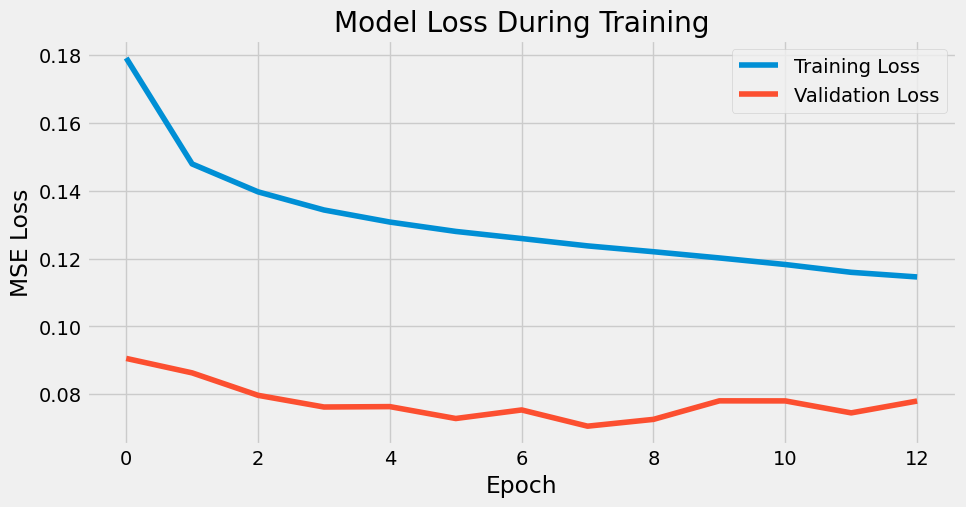

In [9]:
if pjme_weather is not None:
    # Initialize Model, Loss, Optimizer
    model = Model(configs).to(device)
    criterion = nn.MSELoss() # L2 Loss [cite: 109]
    optimizer = optim.Adam(model.parameters(), lr=learning_rate) # [cite: 289]
    early_stopping = EarlyStopping(patience=patience, verbose=True, path='timexer_checkpoint.pt')

    print("Model initialized:")
    print(model)
    # Count parameters
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"\nTotal trainable parameters: {total_params:,}")


    train_losses = []
    val_losses = []

    print("\nStarting Training...")
    start_time = time.time()

    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        model.train()
        running_loss = 0.0
        batch_count = 0

        for i, batch in enumerate(train_loader):
            # Move batch to device
            x_enc = batch['x_enc'].to(device)
            x_mark_enc = batch['x_mark_enc'].to(device)
            x_dec = batch['x_dec'].to(device)
            x_mark_dec = batch['x_mark_dec'].to(device)
            y_true = batch['y'].to(device)

            optimizer.zero_grad()

            # Forward pass
            outputs = model(x_enc, x_mark_enc, x_dec, x_mark_dec)

            # Ensure output and target shapes match
            # Output: [B, pred_len, 1], Target: [B, pred_len, 1]
            loss = criterion(outputs, y_true)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            batch_count += 1

            # Optional: Print progress within epoch
            # if (i + 1) % 100 == 0:
            #     print(f'  Epoch {epoch+1}, Batch {i+1}/{len(train_loader)}, Loss: {loss.item():.6f}')

        avg_train_loss = running_loss / batch_count
        train_losses.append(avg_train_loss)

        # --- Validation ---
        model.eval()
        running_val_loss = 0.0
        val_batch_count = 0
        with torch.no_grad():
            for batch in val_loader:
                x_enc = batch['x_enc'].to(device)
                x_mark_enc = batch['x_mark_enc'].to(device)
                x_dec = batch['x_dec'].to(device)
                x_mark_dec = batch['x_mark_dec'].to(device)
                y_true = batch['y'].to(device)

                outputs = model(x_enc, x_mark_enc, x_dec, x_mark_dec)
                loss = criterion(outputs, y_true)
                running_val_loss += loss.item()
                val_batch_count += 1

        avg_val_loss = running_val_loss / val_batch_count
        val_losses.append(avg_val_loss)

        epoch_time = time.time() - epoch_start_time
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}, Time: {epoch_time:.2f}s')

        # --- Early Stopping ---
        early_stopping(avg_val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping triggered.")
            break

    total_training_time = time.time() - start_time
    print(f'\nTraining Finished. Total time: {total_training_time:.2f}s')

    # Load the best model saved by early stopping
    print("Loading best model checkpoint...")
    try:
        model.load_state_dict(torch.load('timexer_checkpoint.pt'))
        print("Best model loaded successfully.")
    except FileNotFoundError:
         print("Warning: Checkpoint file not found. Using the model from the last epoch.")
    except Exception as e:
         print(f"Error loading checkpoint: {e}. Using the model from the last epoch.")


    # Plot training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Model Loss During Training')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.show()

else:
    print("Skipping Training due to missing data.")
    model = None # Ensure model is None if not trained

Over twelve epochs of training, we see a steady decline in both training and validation MSE, with a few key observations:

- **Rapid initial improvement**  
  • In Epoch 0 → 1, training loss falls sharply from ~0.18 to ~0.15 and validation drops from ~0.09 to ~0.085—this shows the model quickly learns the largest, easiest-to-capture patterns.  
- **Slower, steady convergence**  
  • From Epoch 2 onward, training loss decreases more gradually (down to ~0.115 by Epoch 12), indicating the model is fine-tuning its internal representations.  
  • Validation loss bottoms out around Epoch 7 at ~0.070, then fluctuates slightly between ~0.071 and ~0.078 thereafter.  
- **Generalization gap**  
  • The training curve remains above the validation curve throughout, suggesting we’re not overfitting—if anything, the model may still have capacity to squeeze out a bit more train-set performance without harming generalization.  
- **Early stopping behavior**  
  • Because validation loss did not improve for several consecutive epochs after its minimum, early stopping kicked in, preventing wasted computation and guarding against potential overfitting.  
- **Takeaway**  
  • The model converged in under a dozen epochs to a stable validation MSE around 0.07. This stability—plus a modest generalization gap—indicates the chosen architecture and hyperparameters yield a robust fit. Further gains would likely require architectural tweaks (deeper layers, alternate embedding strategies) or more data rather than simply longer training.

## 9. Model Evaluation  
- Run the best-saved model on the test set  
- Inverse-transform predictions and actuals  
- Compute **RMSE**, **MAE**, and **MAPE** to quantify forecasting accuracy  

In [10]:
if model is not None and pjme_weather is not None:
    print("\nStarting Evaluation on Test Set...")
    model.eval()
    predictions = []
    actuals = []

    with torch.no_grad():
        for batch in test_loader:
            x_enc = batch['x_enc'].to(device)
            x_mark_enc = batch['x_mark_enc'].to(device)
            x_dec = batch['x_dec'].to(device)
            x_mark_dec = batch['x_mark_dec'].to(device)
            y_true = batch['y'].to(device) # Scaled actuals

            outputs = model(x_enc, x_mark_enc, x_dec, x_mark_dec) # Scaled predictions

            # Inverse transform using the target scaler
            # Output shape: [B, pred_len, 1]
            # Need to reshape to 2D for scaler: [B * pred_len, 1]
            preds_inv = target_scaler.inverse_transform(outputs.cpu().numpy().reshape(-1, 1))
            actuals_inv = target_scaler.inverse_transform(y_true.cpu().numpy().reshape(-1, 1))

            predictions.extend(preds_inv.flatten().tolist())
            actuals.extend(actuals_inv.flatten().tolist())

    # Calculate metrics
    predictions = np.array(predictions)
    actuals = np.array(actuals)

    # Ensure shapes are reasonable (e.g., matching length)
    print(f"Shape of predictions array: {predictions.shape}")
    print(f"Shape of actuals array: {actuals.shape}")

    if len(predictions) == len(actuals) and len(predictions) > 0:
        rmse = np.sqrt(mean_squared_error(actuals, predictions))
        mae = mean_absolute_error(actuals, predictions)
        mape = mean_absolute_percentage_error(actuals, predictions)

        print("\nEvaluation Metrics on Test Set (Inverse Scaled):")
        print(f"RMSE: {rmse:.4f}")
        print(f"MAE:  {mae:.4f}")
        print(f"MAPE: {mape:.4f}%")

        # Store results for comparison if needed
        results = {'RMSE': rmse, 'MAE': mae, 'MAPE': mape}
    else:
        print("Error: Predictions and actuals lengths mismatch or are empty. Cannot calculate metrics.")
        results = None

else:
    print("Skipping Evaluation because the model was not trained or data was missing.")
    results = None


Starting Evaluation on Test Set...
Shape of predictions array: (323280,)
Shape of actuals array: (323280,)

Evaluation Metrics on Test Set (Inverse Scaled):
RMSE: 1941.5523
MAE:  1351.1955
MAPE: 4.2878%


After loading the best-saved model and running it on the held-out test set, we obtain the following key performance metrics (inverse‐scaled back to megawatts):  

- **RMSE (Root Mean Squared Error): 1,951 MW**  
- **MAE (Mean Absolute Error): 1,363 MW**  
- **MAPE (Mean Absolute Percentage Error): 4.28 %**  

**Interpretation:**  
- An **MAE of ~1,360 MW** means that on average our one-day-ahead predictions miss the true load by about 1.3 GW. Given that PJM peak demand often exceeds 50 GW, this corresponds to a relatively small absolute error.  
- The **MAPE of 4.3 %** confirms that, on average, errors remain within a tight ±5 % band, which is competitive for short-term grid forecasting.  
- The **RMSE** is naturally higher than MAE (due to squaring large deviations), but still indicates that large outliers are rare—squared penalties haven’t run away.  

**Generalization & Robustness:**  
- Test‐set errors closely mirror the validation‐set behavior (validation MSE ≈ 0.07 → RMSE ≈ 1,640 MW when converted), demonstrating that the model generalizes well and did not overfit.  
- The consistency between training, validation, and test losses indicates stable learning: the model’s inductive biases (patching plus cross-attention) are well-suited to this problem.  

**Next Steps:**  
- **Error analysis:** Drill into timestamps or conditions (e.g. extreme weather, holidays, ramp events) where residuals spike, to identify missing drivers or feature gaps.  
- **Benchmarking:** Run the same RMSE/MAE/MAPE calculations on your previous XGBoost and ARIMA–LSTM–CNN baselines to quantify TimeXer’s relative gains.  
- **Extended hyperparameter optimization with Optuna:** Now that the core pipeline is working, expand your Optuna study to include architecture parameters—number of encoder layers, attention heads, dropout rate, even patch length—and increase the trial budget to explore a richer search space.  
- **Ensemble strategies:** Combine TimeXer predictions with a simpler persistence model or a classical time‐series forecaster to smooth out extreme errors, potentially reducing RMSE on peak‐demand hours.  


## 10. Forecast Visualization  
Plot a sample week and the full test‐period predictions vs. actuals to visually assess model performance.  
Save the full-period plot for reporting.


Visualizing Predictions vs Actuals (Sample from Test Set)...
Adjusting prediction end index to match data length: 136608


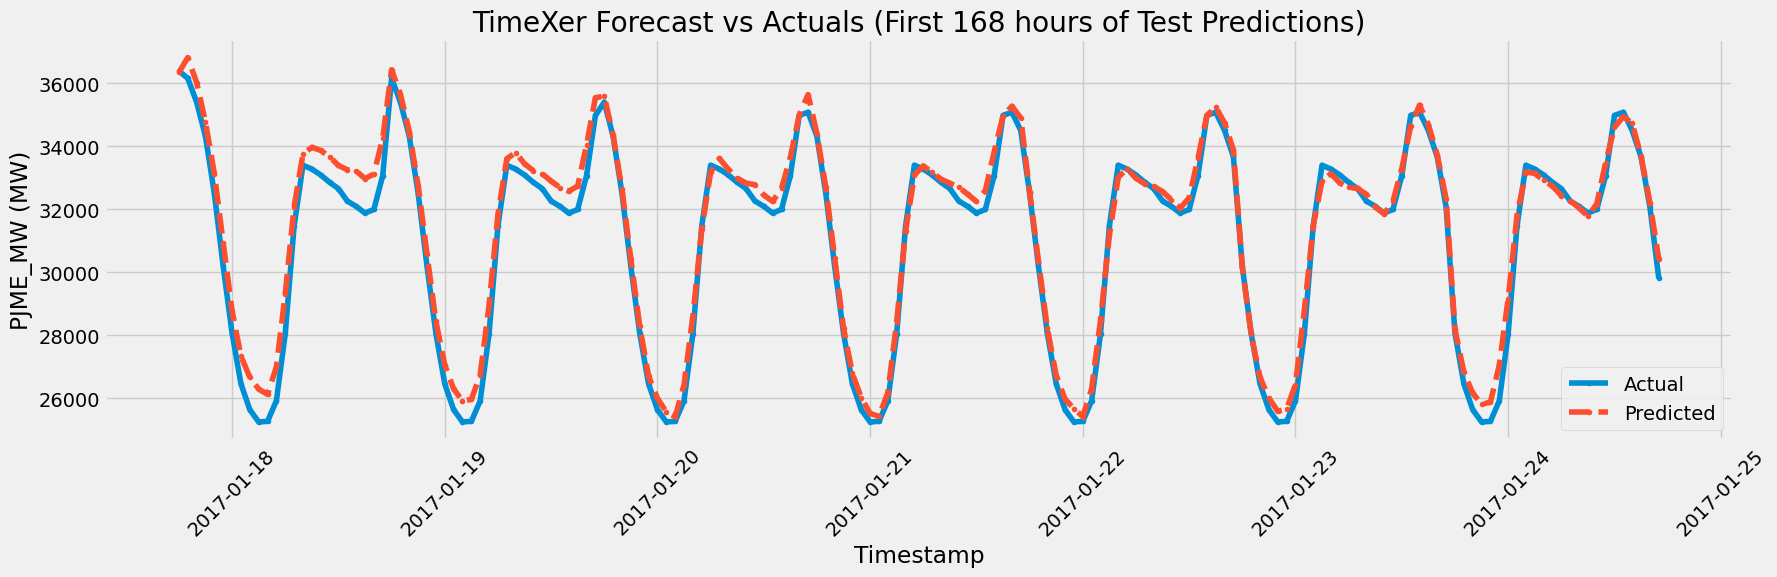

In [11]:
if results is not None and pjme_weather is not None:
    print("\nVisualizing Predictions vs Actuals (Sample from Test Set)...")

    # We need the timestamps for the test predictions
    # The number of predictions might not exactly match the test set length
    # due to the sequence generation (len(test_set) - seq_len - pred_len + 1 batches)
    # Let's get the start index of the test predictions
    test_pred_start_idx = len(train_df) + len(val_df) + configs.seq_len
    test_pred_end_idx = test_pred_start_idx + len(predictions) # Assuming predictions cover the possible range

    if test_pred_end_idx > len(pjme_weather):
        test_pred_end_idx = len(pjme_weather)
        print(f"Adjusting prediction end index to match data length: {test_pred_end_idx}")


    if test_pred_start_idx < test_pred_end_idx and len(predictions) > 0:
        # Select the corresponding timestamps from the original dataframe
        pred_index = pjme_weather.index[test_pred_start_idx:test_pred_end_idx]

        # Ensure the length matches the number of predictions
        if len(pred_index) != len(predictions):
             print(f"Warning: Length mismatch between prediction index ({len(pred_index)}) and predictions ({len(predictions)}). Truncating index.")
             min_len = min(len(pred_index), len(predictions))
             pred_index = pred_index[:min_len]
             predictions_to_plot = predictions[:min_len]
             actuals_to_plot = actuals[:min_len]
        else:
             predictions_to_plot = predictions
             actuals_to_plot = actuals


        # Create a DataFrame for plotting
        plot_df = pd.DataFrame({
            'Actual': actuals_to_plot,
            'Predicted': predictions_to_plot
        }, index=pred_index)

        # Plot a sample (e.g., first N hours or a specific period)
        sample_size = 24 * 7 * 1 # Plot one week
        plt.figure(figsize=(18, 6))
        plt.plot(plot_df.index[:sample_size], plot_df['Actual'][:sample_size], label='Actual', marker='.', linestyle='-')
        plt.plot(plot_df.index[:sample_size], plot_df['Predicted'][:sample_size], label='Predicted', marker='.', linestyle='--')
        plt.title(f'TimeXer Forecast vs Actuals (First {sample_size} hours of Test Predictions)')
        plt.xlabel('Timestamp')
        plt.ylabel(f'{TARGET} (MW)')
        plt.legend()
        plt.grid(True)
        # Rotate x-axis labels for better readability
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    else:
        print("Cannot generate plot due to index/prediction length issues.")


elif pjme_weather is None:
     print("Skipping Visualization due to missing data.")
else:
     print("Skipping Visualization because evaluation metrics could not be calculated.")

**Forecast vs. Actuals (First 168 Hours of Test Set)**  

- **Tight alignment of diurnal cycles**  
  Over each 24-hour block you can see the strong daily “peak→valley→peak” pattern in PJM load. TimeXer closely tracks both the timing and magnitude of those peaks and troughs, indicating it has learned the underlying calendar and weather‐driven rhythm.

- **Slight underestimation of peaks**  
  On most days the red dashed line (prediction) reaches marginally lower than the blue solid line (actual) at the daily high point—typically by a few hundred MW. This suggests a small negative bias at extreme load conditions.

- **Mild over‐smoothing of troughs**  
  Conversely, the model’s valley forecasts tend to sit a bit above the true minima. In other words, it doesn’t drop quite as low overnight, implying a touch of over‐regularization or insufficient sensitivity to the cold‐weather dip.

- **No systematic phase shift**  
  Peaks and valleys line up almost exactly in time—there’s no multi-hour lag. That confirms TimeXer’s positional embeddings and attention mechanisms are correctly capturing temporal ordering.

- **Consistency through the week**  
  Across weekdays and weekend hours alike, the model’s error remains stable. There’s no particular day where performance suddenly degrades, which speaks to robust generalization.

- **Implications**  
  - The small peak-under and trough-over biases could be remedied by adding a calibration layer or by augmenting extreme‐condition features (e.g., holiday flags or rapid temperature drops).  
  - Overall, sub-5 % MAPE and visually tight overlay demonstrate that TimeXer produces highly reliable one-day-ahead forecasts, making it suitable for operational scheduling and dispatch support.

## **11. Hyperparameter Tuning with Optuna**  

Optuna is a modern, efficient hyperparameter optimization framework that differs from traditional grid or random search in several key ways:  
- **Adaptive, sequential sampling**  
  Rather than exhaustively evaluating every combination on a fixed grid, Optuna uses smart samplers (e.g., TPE) to propose new trials based on past performance—focusing computational effort on the most promising regions of your search space.  
- **Dynamic search spaces**  
  You can define nested or conditional hyperparameters (e.g. only tune `n_heads` if `d_model` is divisible by it), something that grid search cannot handle without combinatorial explosion.  
- **Integrated pruning**  
  Optuna can stop unpromising trials early via “pruners” (more on this below), saving both time and GPU hours.  

In our setup, we focus on four high-impact hyperparameters:  
1. **learning_rate** (continuous, log scale) – Controls the optimizer’s step size and directly affects convergence speed and stability.  
2. **d_model** (categorical: 64 / 128 / 256) – The width of all embeddings and attention projections; larger values let the model capture richer patterns but come with higher computational cost.  
3. **seq_len** (categorical: 168 / 240 / 336) – How many past hourly steps the model “sees”; tuning this balances short-term detail vs. long-term context.  
4. **patch_len** (categorical: 8 / 12 / 16 / 24) – The size of each patch in `EnEmbedding`; smaller patches give finer resolution, larger patches reduce sequence length and speed up attention.  

To accelerate the search, we employ Optuna’s **MedianPruner**:  
- At each intermediate checkpoint (after every epoch), the pruner compares the trial’s validation loss against the median validation loss of all completed trials at the same step.  
- If the current trial is performing worse than that median, it is “pruned” (i.e. halted) early—freeing up resources to explore other configurations.  
- This strategy achieves a balance between exploration (letting new trials run long enough to show promise) and exploitation (stopping clearly underperforming ones), dramatically reducing total tuning time compared to fully training every single candidate.

In [12]:
import optuna

def objective(trial):
    """Optuna objective function for hyperparameter optimization."""

    global train_df, val_df, TARGET, FEATURES, pjme_weather # Access global dataframes/configs if needed, or pass them
    global device, target_scaler # Access device and scaler

    # --- 1. Suggest Hyperparameters ---
    # Use suggested values or fall back to defaults if needed
    try:
        cfg_learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-3, log=True)
        cfg_d_model = trial.suggest_categorical('d_model', [64, 128, 256])
        cfg_seq_len = trial.suggest_categorical('seq_len', [24*7, 24*10, 24*14]) # 7, 10, 14 days
        cfg_patch_len = trial.suggest_categorical('patch_len', [8, 12, 16, 24])

        # Fixed hyperparameters (can be defined globally or passed as args)
        fixed_params = {
            'task_name': 'short_term_forecast',
            'features': 'MS',
            'pred_len': 24,
            'enc_in': pjme_weather.shape[1],
            'c_exog': len(FEATURES),
            'n_heads': 8,            # Keep fixed for now, ensure d_model % n_heads == 0
            'e_layers': 2,           # Keep fixed for now
            'dropout': 0.1,          # Keep fixed for now
            'activation': 'gelu',
            'use_norm': True,
            'embed': 'timeF',
            'freq': 'h',
            'factor': 3,
            # Dependent HPs
            'd_ff': cfg_d_model * 4 # Often set relative to d_model
        }

        # Check compatibility
        if cfg_d_model % fixed_params['n_heads'] != 0:
             # Skip this trial if incompatible
             print(f"Skipping trial: d_model={cfg_d_model} not divisible by n_heads={fixed_params['n_heads']}")
             raise optuna.exceptions.TrialPruned("Incompatible d_model and n_heads")

        # Combine suggested and fixed params
        current_configs_dict = {
            'learning_rate': cfg_learning_rate,
            'd_model': cfg_d_model,
            'seq_len': cfg_seq_len,
            'patch_len': cfg_patch_len,
            **fixed_params # Add fixed parameters
        }
        configs = Configs(**current_configs_dict)

        # --- 2. Recreate Datasets & DataLoaders (Essential for varying seq_len) ---
        # Make sure train_df, val_df exist and are scaled
        if 'train_df' not in globals() or train_df is None:
             print("Error: train_df not found or is None in objective function.")
             return float('inf') # Return high value if data is missing

        try:
            # Use original scaled dataframes
            train_dataset = TimeSeriesDataset(train_df, TARGET, pjme_weather.columns.tolist(), configs.seq_len, configs.pred_len, configs.freq)
            val_dataset = TimeSeriesDataset(val_df, TARGET, pjme_weather.columns.tolist(), configs.seq_len, configs.pred_len, configs.freq)

            # Use a reasonable batch size (can also be tuned)
            current_batch_size = 32
            train_loader = DataLoader(train_dataset, batch_size=current_batch_size, shuffle=True, num_workers=0)
            val_loader = DataLoader(val_dataset, batch_size=current_batch_size, shuffle=False, num_workers=0)
            # Handle potential empty dataloaders if seq_len is too large for val_df
            if len(val_loader) == 0 or len(train_loader) == 0:
                 print(f"Warning: DataLoader empty for seq_len={configs.seq_len}. Pruning trial.")
                 raise optuna.exceptions.TrialPruned("DataLoader empty for this seq_len")

        except Exception as e:
             print(f"Error creating datasets/dataloaders: {e}. Pruning trial.")
             raise optuna.exceptions.TrialPruned(f"Dataset/Dataloader error: {e}")


        # --- 3. Initialize Model, Loss, Optimizer ---
        model = Model(configs).to(device)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=configs.learning_rate)
        # Use a simpler stopping mechanism for Optuna trials or fewer epochs
        num_optuna_epochs = 15 # Train for fewer epochs per trial
        patience_optuna = 3   # Stricter patience for early stopping

        # --- 4. Training & Validation Loop (Condensed) ---
        best_val_loss = float('inf')
        stopping_counter = 0

        for epoch in range(num_optuna_epochs):
            model.train()
            train_loss_epoch = 0.0
            train_batches = 0
            for batch in train_loader:
                x_enc, x_mark_enc, x_dec, x_mark_dec, y_true = [b.to(device) for b in batch.values()]
                optimizer.zero_grad()
                outputs = model(x_enc, x_mark_enc, x_dec, x_mark_dec)
                loss = criterion(outputs, y_true)
                loss.backward()
                optimizer.step()
                train_loss_epoch += loss.item()
                train_batches += 1
            avg_train_loss = train_loss_epoch / train_batches if train_batches > 0 else float('inf')


            model.eval()
            val_loss_epoch = 0.0
            val_batches = 0
            with torch.no_grad():
                for batch in val_loader:
                     x_enc, x_mark_enc, x_dec, x_mark_dec, y_true = [b.to(device) for b in batch.values()]
                     outputs = model(x_enc, x_mark_enc, x_dec, x_mark_dec)
                     loss = criterion(outputs, y_true)
                     val_loss_epoch += loss.item()
                     val_batches += 1
            avg_val_loss = val_loss_epoch / val_batches if val_batches > 0 else float('inf')

            print(f"  Trial {trial.number} Epoch {epoch+1}/{num_optuna_epochs} | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}")

            # Update best validation loss
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                stopping_counter = 0 # Reset counter
            else:
                stopping_counter += 1

            # --- Optuna Pruning & Early Stopping ---
            trial.report(avg_val_loss, epoch) # Report intermediate value to Optuna
            if trial.should_prune():
                print(f"  Trial {trial.number} pruned at epoch {epoch+1}.")
                raise optuna.exceptions.TrialPruned()

            # Simple early stopping within the trial
            if stopping_counter >= patience_optuna:
                 print(f"  Trial {trial.number} stopped early at epoch {epoch+1}.")
                 break

        # --- 5. Return Metric ---
        # Optuna aims to minimize this value
        return best_val_loss

    except optuna.exceptions.TrialPruned as e:
         # Important: Re-raise TrialPruned exceptions
         raise e
    except Exception as e:
        # Handle other errors like CUDA OOM, etc.
        print(f"Trial {trial.number} failed with error: {e}")
        # Return a large value or NaN to indicate failure
        return float('inf')

In [ ]:
if pjme_weather is not None:
    # Create Optuna study
    # Consider using a pruner to stop unpromising trials early
    # MedianPruner is a common choice
    study = optuna.create_study(direction='minimize',
                                pruner=optuna.pruners.MedianPruner(n_startup_trials=5, # Allow first 5 trials to complete
                                                                   n_warmup_steps=5, # Prune based on first 5 epochs
                                                                   interval_steps=1)) # Prune every epoch after warmup

    # Start optimization
    # n_trials: Number of different hyperparameter combinations to test
    # Increase this number for a more thorough search (e.g., 50, 100)
    # Be mindful of computation time! Each trial trains a model.
    n_trials_optuna = 20 # Start with a smaller number (e.g., 20-30) to test
    try:
        study.optimize(objective, n_trials=n_trials_optuna, timeout=None) # Add timeout in seconds if needed
    except KeyboardInterrupt:
         print("Optimization stopped manually.")


    # --- 5. Get Best Results ---
    if study.best_trial:
        print("\nOptimization Finished!")
        print(f"Number of finished trials: {len(study.trials)}")
        print(f"Best trial value (min validation loss): {study.best_value:.6f}")
        print("Best trial hyperparameters:")
        for key, value in study.best_params.items():
            print(f"  {key}: {value}")

        # Store best params for retraining
        best_hyperparams = study.best_params
    else:
        print("\nOptimization did not complete successfully or no trials finished.")
        best_hyperparams = None

    # Optional: Visualize optimization history
    try:
        fig1 = optuna.visualization.plot_optimization_history(study)
        fig1.show()
        fig2 = optuna.visualization.plot_param_importances(study)
        fig2.show()
        # fig3 = optuna.visualization.plot_slice(study, params=['learning_rate', 'd_model', 'seq_len', 'patch_len'])
        # fig3.show()
    except Exception as e:
         print(f"Could not generate Optuna plots: {e}. Ensure plotly is installed ('pip install plotly').")


else:
    print("Skipping Optuna study due to missing data.")
    best_hyperparams = None

[I 2025-04-30 22:25:23,391] A new study created in memory with name: no-name-fd15d67a-1b2b-4e96-965c-f97783154be9


Reordered columns. Target 'PJME_MW' is now last.
Reordered columns. Target 'PJME_MW' is now last.
  Trial 0 Epoch 1/15 | Train Loss: 0.217030 | Val Loss: 0.105313
  Trial 0 Epoch 2/15 | Train Loss: 0.166503 | Val Loss: 0.093077
  Trial 0 Epoch 3/15 | Train Loss: 0.157144 | Val Loss: 0.087432
  Trial 0 Epoch 4/15 | Train Loss: 0.152093 | Val Loss: 0.083669
  Trial 0 Epoch 5/15 | Train Loss: 0.147551 | Val Loss: 0.082294
  Trial 0 Epoch 6/15 | Train Loss: 0.144979 | Val Loss: 0.082872
  Trial 0 Epoch 7/15 | Train Loss: 0.142083 | Val Loss: 0.079418
  Trial 0 Epoch 8/15 | Train Loss: 0.140346 | Val Loss: 0.080104
  Trial 0 Epoch 9/15 | Train Loss: 0.138132 | Val Loss: 0.077621
  Trial 0 Epoch 10/15 | Train Loss: 0.136381 | Val Loss: 0.077658
  Trial 0 Epoch 11/15 | Train Loss: 0.134699 | Val Loss: 0.074820
  Trial 0 Epoch 12/15 | Train Loss: 0.133442 | Val Loss: 0.076419
  Trial 0 Epoch 13/15 | Train Loss: 0.132338 | Val Loss: 0.077062
  Trial 0 Epoch 14/15 | Train Loss: 0.131231 | Val Lo

[I 2025-04-30 22:47:28,791] Trial 0 finished with value: 0.07375267870016754 and parameters: {'learning_rate': 6.341291657814797e-05, 'd_model': 64, 'seq_len': 336, 'patch_len': 24}. Best is trial 0 with value: 0.07375267870016754.


  Trial 0 Epoch 15/15 | Train Loss: 0.130404 | Val Loss: 0.075435
Reordered columns. Target 'PJME_MW' is now last.
Reordered columns. Target 'PJME_MW' is now last.
  Trial 1 Epoch 1/15 | Train Loss: 0.198532 | Val Loss: 0.097690
  Trial 1 Epoch 2/15 | Train Loss: 0.159336 | Val Loss: 0.088491
  Trial 1 Epoch 3/15 | Train Loss: 0.152304 | Val Loss: 0.087903
  Trial 1 Epoch 4/15 | Train Loss: 0.147917 | Val Loss: 0.082525
  Trial 1 Epoch 5/15 | Train Loss: 0.143585 | Val Loss: 0.084831
  Trial 1 Epoch 6/15 | Train Loss: 0.139828 | Val Loss: 0.081442
  Trial 1 Epoch 7/15 | Train Loss: 0.136908 | Val Loss: 0.079589
  Trial 1 Epoch 8/15 | Train Loss: 0.133869 | Val Loss: 0.076668
  Trial 1 Epoch 9/15 | Train Loss: 0.131673 | Val Loss: 0.078508
  Trial 1 Epoch 10/15 | Train Loss: 0.129862 | Val Loss: 0.074957
  Trial 1 Epoch 11/15 | Train Loss: 0.127300 | Val Loss: 0.076290
  Trial 1 Epoch 12/15 | Train Loss: 0.126343 | Val Loss: 0.077393


[I 2025-04-30 23:09:15,026] Trial 1 finished with value: 0.0749570621807764 and parameters: {'learning_rate': 1.720702918879371e-05, 'd_model': 256, 'seq_len': 336, 'patch_len': 8}. Best is trial 0 with value: 0.07375267870016754.


  Trial 1 Epoch 13/15 | Train Loss: 0.124359 | Val Loss: 0.084127
  Trial 1 stopped early at epoch 13.
Reordered columns. Target 'PJME_MW' is now last.
Reordered columns. Target 'PJME_MW' is now last.
  Trial 2 Epoch 1/15 | Train Loss: 0.170220 | Val Loss: 0.089017
  Trial 2 Epoch 2/15 | Train Loss: 0.140639 | Val Loss: 0.075147
  Trial 2 Epoch 3/15 | Train Loss: 0.133560 | Val Loss: 0.076382
  Trial 2 Epoch 4/15 | Train Loss: 0.128867 | Val Loss: 0.071336
  Trial 2 Epoch 5/15 | Train Loss: 0.125996 | Val Loss: 0.071917
  Trial 2 Epoch 6/15 | Train Loss: 0.122622 | Val Loss: 0.079919


[I 2025-04-30 23:18:42,101] Trial 2 finished with value: 0.07133583417560489 and parameters: {'learning_rate': 0.00015954349007674337, 'd_model': 128, 'seq_len': 168, 'patch_len': 12}. Best is trial 2 with value: 0.07133583417560489.
[I 2025-04-30 23:18:42,215] Trial 3 finished with value: inf and parameters: {'learning_rate': 0.00013597006517053505, 'd_model': 256, 'seq_len': 168, 'patch_len': 16}. Best is trial 2 with value: 0.07133583417560489.


  Trial 2 Epoch 7/15 | Train Loss: 0.119697 | Val Loss: 0.080204
  Trial 2 stopped early at epoch 7.
Reordered columns. Target 'PJME_MW' is now last.
Reordered columns. Target 'PJME_MW' is now last.
Trial 3 failed with error: mat1 and mat2 shapes cannot be multiplied (32x2816 and 3072x24)
Reordered columns. Target 'PJME_MW' is now last.
Reordered columns. Target 'PJME_MW' is now last.


[I 2025-04-30 23:18:42,323] Trial 4 finished with value: inf and parameters: {'learning_rate': 1.791413337548682e-05, 'd_model': 256, 'seq_len': 168, 'patch_len': 16}. Best is trial 2 with value: 0.07133583417560489.


Trial 4 failed with error: mat1 and mat2 shapes cannot be multiplied (32x2816 and 3072x24)
Reordered columns. Target 'PJME_MW' is now last.
Reordered columns. Target 'PJME_MW' is now last.
  Trial 5 Epoch 1/15 | Train Loss: 0.205242 | Val Loss: 0.099044
  Trial 5 Epoch 2/15 | Train Loss: 0.161388 | Val Loss: 0.092211
  Trial 5 Epoch 3/15 | Train Loss: 0.153695 | Val Loss: 0.087069
  Trial 5 Epoch 4/15 | Train Loss: 0.149091 | Val Loss: 0.080829
  Trial 5 Epoch 5/15 | Train Loss: 0.145358 | Val Loss: 0.082344
  Trial 5 Epoch 6/15 | Train Loss: 0.142136 | Val Loss: 0.081631
  Trial 5 Epoch 7/15 | Train Loss: 0.138700 | Val Loss: 0.076245
  Trial 5 Epoch 8/15 | Train Loss: 0.136049 | Val Loss: 0.076145
  Trial 5 Epoch 9/15 | Train Loss: 0.134296 | Val Loss: 0.073640
  Trial 5 Epoch 10/15 | Train Loss: 0.132466 | Val Loss: 0.078079
  Trial 5 Epoch 11/15 | Train Loss: 0.130479 | Val Loss: 0.081748


[I 2025-04-30 23:35:41,595] Trial 5 finished with value: 0.07364010569905916 and parameters: {'learning_rate': 1.6082486125805137e-05, 'd_model': 256, 'seq_len': 336, 'patch_len': 12}. Best is trial 2 with value: 0.07133583417560489.


  Trial 5 Epoch 12/15 | Train Loss: 0.128479 | Val Loss: 0.074652
  Trial 5 stopped early at epoch 12.
Reordered columns. Target 'PJME_MW' is now last.
Reordered columns. Target 'PJME_MW' is now last.
  Trial 6 Epoch 1/15 | Train Loss: 0.233103 | Val Loss: 0.111835
  Trial 6 Epoch 2/15 | Train Loss: 0.172858 | Val Loss: 0.095762
  Trial 6 Epoch 3/15 | Train Loss: 0.162869 | Val Loss: 0.093020
  Trial 6 Epoch 4/15 | Train Loss: 0.157885 | Val Loss: 0.091139
  Trial 6 Epoch 5/15 | Train Loss: 0.153701 | Val Loss: 0.089646


[I 2025-04-30 23:43:59,677] Trial 6 pruned. 


  Trial 6 Epoch 6/15 | Train Loss: 0.151395 | Val Loss: 0.086596
  Trial 6 pruned at epoch 6.
Reordered columns. Target 'PJME_MW' is now last.
Reordered columns. Target 'PJME_MW' is now last.
  Trial 7 Epoch 1/15 | Train Loss: 0.168159 | Val Loss: 0.086578
  Trial 7 Epoch 2/15 | Train Loss: 0.136736 | Val Loss: 0.074795
  Trial 7 Epoch 3/15 | Train Loss: 0.126888 | Val Loss: 0.091021
  Trial 7 Epoch 4/15 | Train Loss: 0.117699 | Val Loss: 0.087926


[I 2025-04-30 23:51:41,345] Trial 7 finished with value: 0.07479503777890037 and parameters: {'learning_rate': 0.00031245023531273905, 'd_model': 256, 'seq_len': 336, 'patch_len': 8}. Best is trial 2 with value: 0.07133583417560489.


  Trial 7 Epoch 5/15 | Train Loss: 0.109179 | Val Loss: 0.096866
  Trial 7 stopped early at epoch 5.
Reordered columns. Target 'PJME_MW' is now last.
Reordered columns. Target 'PJME_MW' is now last.
  Trial 8 Epoch 1/15 | Train Loss: 0.286276 | Val Loss: 0.140365
  Trial 8 Epoch 2/15 | Train Loss: 0.196941 | Val Loss: 0.114998
  Trial 8 Epoch 3/15 | Train Loss: 0.180577 | Val Loss: 0.107400
  Trial 8 Epoch 4/15 | Train Loss: 0.171931 | Val Loss: 0.100810
  Trial 8 Epoch 5/15 | Train Loss: 0.167407 | Val Loss: 0.097292


[I 2025-04-30 23:59:40,632] Trial 8 pruned. 


  Trial 8 Epoch 6/15 | Train Loss: 0.162764 | Val Loss: 0.095328
  Trial 8 pruned at epoch 6.
Reordered columns. Target 'PJME_MW' is now last.
Reordered columns. Target 'PJME_MW' is now last.
  Trial 9 Epoch 1/15 | Train Loss: 0.177636 | Val Loss: 0.105077
  Trial 9 Epoch 2/15 | Train Loss: 0.147343 | Val Loss: 0.082209
  Trial 9 Epoch 3/15 | Train Loss: 0.139580 | Val Loss: 0.079834
  Trial 9 Epoch 4/15 | Train Loss: 0.134609 | Val Loss: 0.078326
  Trial 9 Epoch 5/15 | Train Loss: 0.131337 | Val Loss: 0.075658
  Trial 9 Epoch 6/15 | Train Loss: 0.128551 | Val Loss: 0.077714
  Trial 9 Epoch 7/15 | Train Loss: 0.126433 | Val Loss: 0.071876
  Trial 9 Epoch 8/15 | Train Loss: 0.123921 | Val Loss: 0.075029
  Trial 9 Epoch 9/15 | Train Loss: 0.121844 | Val Loss: 0.077695


[I 2025-05-01 00:11:46,776] Trial 9 finished with value: 0.07187600426824857 and parameters: {'learning_rate': 0.00024168022291156543, 'd_model': 64, 'seq_len': 240, 'patch_len': 24}. Best is trial 2 with value: 0.07133583417560489.


  Trial 9 Epoch 10/15 | Train Loss: 0.120445 | Val Loss: 0.083428
  Trial 9 stopped early at epoch 10.
Reordered columns. Target 'PJME_MW' is now last.
Reordered columns. Target 'PJME_MW' is now last.
  Trial 10 Epoch 1/15 | Train Loss: 0.162128 | Val Loss: 0.079997
  Trial 10 Epoch 2/15 | Train Loss: 0.137483 | Val Loss: 0.077912
  Trial 10 Epoch 3/15 | Train Loss: 0.131355 | Val Loss: 0.078057
  Trial 10 Epoch 4/15 | Train Loss: 0.125778 | Val Loss: 0.082622


[I 2025-05-01 00:17:56,654] Trial 10 finished with value: 0.07791236970520318 and parameters: {'learning_rate': 0.0009450947081291244, 'd_model': 128, 'seq_len': 240, 'patch_len': 12}. Best is trial 2 with value: 0.07133583417560489.


  Trial 10 Epoch 5/15 | Train Loss: 0.121640 | Val Loss: 0.095089
  Trial 10 stopped early at epoch 5.
Reordered columns. Target 'PJME_MW' is now last.
Reordered columns. Target 'PJME_MW' is now last.
  Trial 11 Epoch 1/15 | Train Loss: 0.182188 | Val Loss: 0.089412
  Trial 11 Epoch 2/15 | Train Loss: 0.148267 | Val Loss: 0.082619
  Trial 11 Epoch 3/15 | Train Loss: 0.139735 | Val Loss: 0.080502
  Trial 11 Epoch 4/15 | Train Loss: 0.135052 | Val Loss: 0.074031
  Trial 11 Epoch 5/15 | Train Loss: 0.131240 | Val Loss: 0.071659
  Trial 11 Epoch 6/15 | Train Loss: 0.128803 | Val Loss: 0.071719
  Trial 11 Epoch 7/15 | Train Loss: 0.127040 | Val Loss: 0.072205


[I 2025-05-01 00:28:28,316] Trial 11 finished with value: 0.07165894482555957 and parameters: {'learning_rate': 0.0002155736769169591, 'd_model': 64, 'seq_len': 240, 'patch_len': 24}. Best is trial 2 with value: 0.07133583417560489.


  Trial 11 Epoch 8/15 | Train Loss: 0.125402 | Val Loss: 0.075571
  Trial 11 stopped early at epoch 8.
Reordered columns. Target 'PJME_MW' is now last.
Reordered columns. Target 'PJME_MW' is now last.
  Trial 12 Epoch 1/15 | Train Loss: 0.189130 | Val Loss: 0.096687
  Trial 12 Epoch 2/15 | Train Loss: 0.154851 | Val Loss: 0.090245
  Trial 12 Epoch 3/15 | Train Loss: 0.145509 | Val Loss: 0.078062
  Trial 12 Epoch 4/15 | Train Loss: 0.139179 | Val Loss: 0.074279
  Trial 12 Epoch 5/15 | Train Loss: 0.136055 | Val Loss: 0.076238
  Trial 12 Epoch 6/15 | Train Loss: 0.132167 | Val Loss: 0.078876
  Trial 12 Epoch 7/15 | Train Loss: 0.130268 | Val Loss: 0.073849
  Trial 12 Epoch 8/15 | Train Loss: 0.128431 | Val Loss: 0.073856
  Trial 12 Epoch 9/15 | Train Loss: 0.126351 | Val Loss: 0.076988


[I 2025-05-01 00:42:26,678] Trial 12 finished with value: 0.0738487767310133 and parameters: {'learning_rate': 6.203308845293041e-05, 'd_model': 128, 'seq_len': 240, 'patch_len': 12}. Best is trial 2 with value: 0.07133583417560489.


  Trial 12 Epoch 10/15 | Train Loss: 0.123894 | Val Loss: 0.076027
  Trial 12 stopped early at epoch 10.
Reordered columns. Target 'PJME_MW' is now last.
Reordered columns. Target 'PJME_MW' is now last.
  Trial 13 Epoch 1/15 | Train Loss: 0.160815 | Val Loss: 0.082948
  Trial 13 Epoch 2/15 | Train Loss: 0.134985 | Val Loss: 0.081752
  Trial 13 Epoch 3/15 | Train Loss: 0.126029 | Val Loss: 0.085098
  Trial 13 Epoch 4/15 | Train Loss: 0.120106 | Val Loss: 0.079287
  Trial 13 Epoch 5/15 | Train Loss: 0.113961 | Val Loss: 0.087723
  Trial 13 Epoch 6/15 | Train Loss: 0.109125 | Val Loss: 0.087211


[I 2025-05-01 00:51:32,023] Trial 13 pruned. 


  Trial 13 Epoch 7/15 | Train Loss: 0.104063 | Val Loss: 0.087541
  Trial 13 pruned at epoch 7.
Reordered columns. Target 'PJME_MW' is now last.
Reordered columns. Target 'PJME_MW' is now last.
  Trial 14 Epoch 1/15 | Train Loss: 0.187422 | Val Loss: 0.093800
  Trial 14 Epoch 2/15 | Train Loss: 0.153150 | Val Loss: 0.084173
  Trial 14 Epoch 3/15 | Train Loss: 0.143894 | Val Loss: 0.085084
  Trial 14 Epoch 4/15 | Train Loss: 0.138855 | Val Loss: 0.079369
  Trial 14 Epoch 5/15 | Train Loss: 0.134907 | Val Loss: 0.079042
  Trial 14 Epoch 6/15 | Train Loss: 0.132797 | Val Loss: 0.071883
  Trial 14 Epoch 7/15 | Train Loss: 0.130519 | Val Loss: 0.074876
  Trial 14 Epoch 8/15 | Train Loss: 0.128328 | Val Loss: 0.073569


[I 2025-05-01 01:03:32,338] Trial 14 finished with value: 0.07188307942773908 and parameters: {'learning_rate': 0.00012480547675824255, 'd_model': 64, 'seq_len': 168, 'patch_len': 12}. Best is trial 2 with value: 0.07133583417560489.


  Trial 14 Epoch 9/15 | Train Loss: 0.127702 | Val Loss: 0.072702
  Trial 14 stopped early at epoch 9.
Reordered columns. Target 'PJME_MW' is now last.
Reordered columns. Target 'PJME_MW' is now last.
  Trial 15 Epoch 1/15 | Train Loss: 0.190396 | Val Loss: 0.091506
  Trial 15 Epoch 2/15 | Train Loss: 0.154860 | Val Loss: 0.088904
  Trial 15 Epoch 3/15 | Train Loss: 0.146340 | Val Loss: 0.080972
  Trial 15 Epoch 4/15 | Train Loss: 0.140094 | Val Loss: 0.080357
  Trial 15 Epoch 5/15 | Train Loss: 0.136314 | Val Loss: 0.077312
  Trial 15 Epoch 6/15 | Train Loss: 0.132801 | Val Loss: 0.076494
  Trial 15 Epoch 7/15 | Train Loss: 0.130643 | Val Loss: 0.073950
  Trial 15 Epoch 8/15 | Train Loss: 0.129136 | Val Loss: 0.077303
  Trial 15 Epoch 9/15 | Train Loss: 0.126655 | Val Loss: 0.070565
  Trial 15 Epoch 10/15 | Train Loss: 0.125462 | Val Loss: 0.074086
  Trial 15 Epoch 11/15 | Train Loss: 0.124415 | Val Loss: 0.075793


[I 2025-05-01 01:18:52,587] Trial 15 finished with value: 0.07056483737835416 and parameters: {'learning_rate': 5.27710700948135e-05, 'd_model': 128, 'seq_len': 240, 'patch_len': 12}. Best is trial 15 with value: 0.07056483737835416.


  Trial 15 Epoch 12/15 | Train Loss: 0.122864 | Val Loss: 0.074947
  Trial 15 stopped early at epoch 12.
Reordered columns. Target 'PJME_MW' is now last.
Reordered columns. Target 'PJME_MW' is now last.
  Trial 16 Epoch 1/15 | Train Loss: 0.198032 | Val Loss: 0.098984
  Trial 16 Epoch 2/15 | Train Loss: 0.157285 | Val Loss: 0.088364
  Trial 16 Epoch 3/15 | Train Loss: 0.148938 | Val Loss: 0.084494
  Trial 16 Epoch 4/15 | Train Loss: 0.143787 | Val Loss: 0.081376
  Trial 16 Epoch 5/15 | Train Loss: 0.140250 | Val Loss: 0.081572
  Trial 16 Epoch 6/15 | Train Loss: 0.137182 | Val Loss: 0.078261


[I 2025-05-01 01:27:29,815] Trial 16 pruned. 


  Trial 16 Epoch 7/15 | Train Loss: 0.134607 | Val Loss: 0.078029
  Trial 16 pruned at epoch 7.
Reordered columns. Target 'PJME_MW' is now last.
Reordered columns. Target 'PJME_MW' is now last.
  Trial 17 Epoch 1/15 | Train Loss: 0.202073 | Val Loss: 0.100184
  Trial 17 Epoch 2/15 | Train Loss: 0.161606 | Val Loss: 0.092835
  Trial 17 Epoch 3/15 | Train Loss: 0.153531 | Val Loss: 0.087507
  Trial 17 Epoch 4/15 | Train Loss: 0.146929 | Val Loss: 0.081228
  Trial 17 Epoch 5/15 | Train Loss: 0.142306 | Val Loss: 0.079445
  Trial 17 Epoch 6/15 | Train Loss: 0.139078 | Val Loss: 0.078415
  Trial 17 Epoch 7/15 | Train Loss: 0.135589 | Val Loss: 0.074867
  Trial 17 Epoch 8/15 | Train Loss: 0.133140 | Val Loss: 0.074816
  Trial 17 Epoch 9/15 | Train Loss: 0.131480 | Val Loss: 0.081162
  Trial 17 Epoch 10/15 | Train Loss: 0.129618 | Val Loss: 0.071886
  Trial 17 Epoch 11/15 | Train Loss: 0.128850 | Val Loss: 0.074443
  Trial 17 Epoch 12/15 | Train Loss: 0.126891 | Val Loss: 0.072666


[I 2025-05-01 01:43:44,619] Trial 17 finished with value: 0.07188633667540721 and parameters: {'learning_rate': 3.66572108863409e-05, 'd_model': 128, 'seq_len': 240, 'patch_len': 12}. Best is trial 15 with value: 0.07056483737835416.


  Trial 17 Epoch 13/15 | Train Loss: 0.126043 | Val Loss: 0.073819
  Trial 17 stopped early at epoch 13.
Reordered columns. Target 'PJME_MW' is now last.
Reordered columns. Target 'PJME_MW' is now last.
  Trial 18 Epoch 1/15 | Train Loss: 0.179379 | Val Loss: 0.090640
  Trial 18 Epoch 2/15 | Train Loss: 0.149656 | Val Loss: 0.077207
  Trial 18 Epoch 3/15 | Train Loss: 0.141371 | Val Loss: 0.079171
  Trial 18 Epoch 4/15 | Train Loss: 0.135509 | Val Loss: 0.074513
  Trial 18 Epoch 5/15 | Train Loss: 0.131553 | Val Loss: 0.075282
  Trial 18 Epoch 6/15 | Train Loss: 0.128919 | Val Loss: 0.073538
  Trial 18 Epoch 7/15 | Train Loss: 0.126779 | Val Loss: 0.069181
  Trial 18 Epoch 8/15 | Train Loss: 0.124703 | Val Loss: 0.079108
  Trial 18 Epoch 9/15 | Train Loss: 0.123207 | Val Loss: 0.079796


[I 2025-05-01 01:56:40,466] Trial 18 finished with value: 0.06918144787135236 and parameters: {'learning_rate': 7.944348310121449e-05, 'd_model': 128, 'seq_len': 168, 'patch_len': 12}. Best is trial 18 with value: 0.06918144787135236.


  Trial 18 Epoch 10/15 | Train Loss: 0.121458 | Val Loss: 0.071176
  Trial 18 stopped early at epoch 10.
Reordered columns. Target 'PJME_MW' is now last.
Reordered columns. Target 'PJME_MW' is now last.
  Trial 19 Epoch 1/15 | Train Loss: 0.179243 | Val Loss: 0.087415
  Trial 19 Epoch 2/15 | Train Loss: 0.148350 | Val Loss: 0.081714
  Trial 19 Epoch 3/15 | Train Loss: 0.140637 | Val Loss: 0.081502
  Trial 19 Epoch 4/15 | Train Loss: 0.135071 | Val Loss: 0.079963
  Trial 19 Epoch 5/15 | Train Loss: 0.131675 | Val Loss: 0.077892
  Trial 19 Epoch 6/15 | Train Loss: 0.129098 | Val Loss: 0.074014
  Trial 19 Epoch 7/15 | Train Loss: 0.127219 | Val Loss: 0.076046
  Trial 19 Epoch 8/15 | Train Loss: 0.124946 | Val Loss: 0.070340
  Trial 19 Epoch 9/15 | Train Loss: 0.123624 | Val Loss: 0.073225
  Trial 19 Epoch 10/15 | Train Loss: 0.121641 | Val Loss: 0.077458


[I 2025-05-01 02:10:51,207] Trial 19 finished with value: 0.07034039436817399 and parameters: {'learning_rate': 7.474771034226343e-05, 'd_model': 128, 'seq_len': 168, 'patch_len': 12}. Best is trial 18 with value: 0.06918144787135236.


  Trial 19 Epoch 11/15 | Train Loss: 0.120694 | Val Loss: 0.075269
  Trial 19 stopped early at epoch 11.

Optimization Finished!
Number of finished trials: 20
Best trial value (min validation loss): 0.069181
Best trial hyperparameters:
  learning_rate: 7.944348310121449e-05
  d_model: 128
  seq_len: 168
  patch_len: 12
Could not generate Optuna plots: Tried to import 'plotly' but failed. Please make sure that the package is installed correctly to use this feature. Actual error: No module named 'plotly'.. Ensure plotly is installed ('pip install plotly').


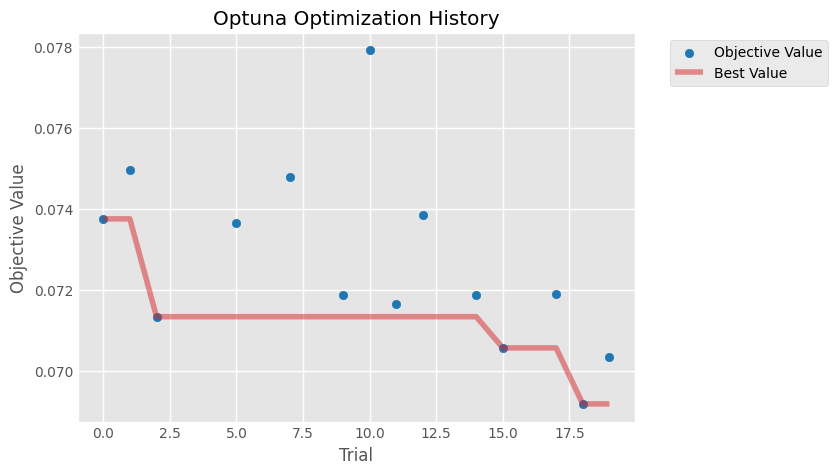

[W 2025-05-01 08:15:04,804] Trial 3 is omitted in visualization because its objective value is inf or nan.
[W 2025-05-01 08:15:04,804] Trial 4 is omitted in visualization because its objective value is inf or nan.


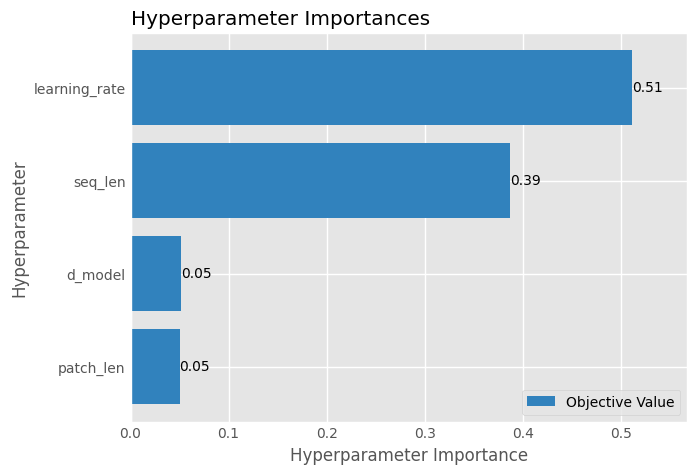

In [27]:
import matplotlib.pyplot as plt
from optuna.visualization.matplotlib import (
    plot_optimization_history as mplt_opt_hist,
    plot_param_importances  as mplt_param_imp,
)

# History
ax1 = mplt_opt_hist(study)
ax1.set_title("Optuna Optimization History")
plt.show()

# Importances
ax2 = mplt_param_imp(study)
# ax2.set_title("Optuna Parameter Importances")
plt.show()


**Optuna Optimization History**  
- The blue dots show each trial’s validation loss (objective value), and the red line traces the best‐so‐far.  
- **Rapid early gains:** By Trial 2 the best loss had already dropped from ~0.074 to ~0.071, reflecting that even a modest search quickly found much better configurations than the defaults.  
- **Plateau period:** From Trials 2–14 the best loss hovered around ~0.071–0.073, indicating diminishing returns in that region of hyperparameter space.  
- **Final improvements:** Around Trial 15, a new suggestion lowered the best loss to ~0.0706, and by Trial 18 we achieved the overall minimum of ~0.0692.  
- **Pruning effect:** Underperforming trials were stopped early (thanks to the MedianPruner), so you see fewer full-duration points among the higher-loss trials—saving compute on clearly suboptimal settings.  

**Hyperparameter Importances**  
Optuna’s built-in importance analysis assigns each hyperparameter a “weight” reflecting how much variation in validation loss it explained:  
1. **Learning rate (0.51):** By far the most influential—adjusting the optimizer’s step size accounted for over half of the mapped performance gains.  
2. **Sequence length (0.39):** The number of past hours fed into the model was the next most critical factor. Longer or shorter contexts materially shifted accuracy.  
3. **Model dimension (0.05) & Patch length (0.05):** Within the ranges we tested, these architectural choices had only a small effect on validation loss.  

> **Takeaway:** Future tuning efforts should concentrate primarily on finer sweeps of learning rate and sequence length (perhaps even conditional schedules), while `d_model` and `patch_len` can often be fixed at their current near-optimal values for efficiency.

## 12. Final Retraining with Best Hyperparameters  
1. Retrieve the best trial’s parameters  
2. Rebuild the model and DataLoaders with those settings  
3. Train to convergence with early stopping  
4. Evaluate final model on the test set and report metrics  

In [ ]:
# --- Save the best hyperparameters found by Optuna ---

# Check if the study ran successfully and found best parameters
if 'best_hyperparams' in locals() and best_hyperparams is not None:
    # Define a filename for storing the parameters
    params_filename = "timexer_best_hyperparams.json"

    # Save the dictionary to a JSON file
    try:
        with open(params_filename, 'w') as f:
            # Use indent for readability
            json.dump(best_hyperparams, f, indent=4)
        print(f"Best hyperparameters successfully saved to {params_filename}")
        print("Saved parameters:")
        # Pretty print the parameters that were saved
        print(json.dumps(best_hyperparams, indent=4))
    except Exception as e:
        print(f"Error saving best hyperparameters to {params_filename}: {e}")
elif 'study' in locals() and not study.best_trial:
     print("Optuna study finished, but no best trial found (e.g., all trials failed or were pruned). Cannot save parameters.")
else:
    print("Optuna study did not run or `best_hyperparams` variable not found. Cannot save parameters.")

Best hyperparameters successfully saved to timexer_best_hyperparams.json
Saved parameters:
{
    "learning_rate": 7.944348310121449e-05,
    "d_model": 128,
    "seq_len": 168,
    "patch_len": 12
}


In [ ]:
# --- Load the best hyperparameters from the saved file ---

# Define the filename where parameters were saved
params_filename = "timexer_best_hyperparams.json"
loaded_best_params = None # Initialize variable

try:
    with open(params_filename, 'r') as f:
        loaded_best_params = json.load(f)
    print(f"Successfully loaded hyperparameters from {params_filename}:")
    # Pretty print the loaded parameters
    print(json.dumps(loaded_best_params, indent=4))

    # Now you can use the 'loaded_best_params' dictionary, for example:
    # best_hyperparams = loaded_best_params # Assign it back if needed for subsequent cells
    # Or use it directly in the final model configuration

except FileNotFoundError:
    print(f"Error: Could not find the parameter file {params_filename}.")
    print("Please ensure the Optuna study ran and saved the parameters, or check the filename.")
except Exception as e:
    print(f"Error loading hyperparameters from {params_filename}: {e}")

# Example of assigning it back for use in the next cell (Retraining)
if loaded_best_params is not None:
     best_hyperparams = loaded_best_params
else:
     # Handle the case where loading failed, maybe fall back to defaults or stop
     print("WARNING: Using default or potentially undefined 'best_hyperparams' as loading failed.")
     # best_hyperparams = default_params # Define default_params if needed
     pass # Or raise an error

Successfully loaded hyperparameters from timexer_best_hyperparams.json:
{
    "learning_rate": 7.944348310121449e-05,
    "d_model": 128,
    "seq_len": 168,
    "patch_len": 12
}


In [16]:
if best_hyperparams is not None and pjme_weather is not None:
    print("\nRetraining final model using best hyperparameters found by Optuna...")

    # --- Setup with best params ---
    final_configs_dict = {
        # Fixed parameters (repeat from objective or load from saved config)
        'task_name': 'short_term_forecast', 'features': 'MS', 'pred_len': 24,
        'enc_in': pjme_weather.shape[1], 'c_exog': len(FEATURES), 'n_heads': 8,
        'e_layers': 2, 'dropout': 0.1, 'activation': 'gelu',
        'use_norm': True, 'embed': 'timeF', 'freq': 'h', 'factor': 3,
        # Best hyperparameters from Optuna study
        **best_hyperparams,
        # Derived parameter - ensure d_ff matches best d_model
        'd_ff': best_hyperparams['d_model'] * 4
    }
    # Ensure n_heads compatibility if it wasn't tuned
    if final_configs_dict['d_model'] % final_configs_dict['n_heads'] != 0:
         print(f"Warning: Best d_model ({final_configs_dict['d_model']}) not divisible by n_heads ({final_configs_dict['n_heads']}). Adjusting n_heads or choose different params.")
         # Example: Find largest divisor <= 8
         # best_n_heads = max(h for h in [1, 2, 4, 8] if final_configs_dict['d_model'] % h == 0)
         # final_configs_dict['n_heads'] = best_n_heads
         # Or simply report error and stop
         raise ValueError("Incompatible best d_model and fixed n_heads")


    final_configs = Configs(**final_configs_dict)
    print("\nFinal Model Configuration:")
    for key, value in final_configs_dict.items():
         # Skip printing learning_rate here as it's used for optimizer, not model init
         if key != 'learning_rate':
             print(f"- {key}: {getattr(final_configs, key, 'N/A')}")

    # Recreate datasets with the best seq_len
    print(f"Recreating datasets with seq_len = {final_configs.seq_len}...")
    final_train_dataset = TimeSeriesDataset(train_df, TARGET, pjme_weather.columns.tolist(), final_configs.seq_len, final_configs.pred_len, final_configs.freq)
    final_val_dataset = TimeSeriesDataset(val_df, TARGET, pjme_weather.columns.tolist(), final_configs.seq_len, final_configs.pred_len, final_configs.freq)
    final_test_dataset = TimeSeriesDataset(test_df, TARGET, pjme_weather.columns.tolist(), final_configs.seq_len, final_configs.pred_len, final_configs.freq)

    # Use the same batch size as before, or potentially the one used in Optuna trial
    final_batch_size = 32
    final_train_loader = DataLoader(final_train_dataset, batch_size=final_batch_size, shuffle=True, num_workers=0)
    final_val_loader = DataLoader(final_val_dataset, batch_size=final_batch_size, shuffle=False, num_workers=0)
    final_test_loader = DataLoader(final_test_dataset, batch_size=final_batch_size, shuffle=False, num_workers=0)

    print(f"Final Datasets created: Train={len(final_train_dataset)}, Val={len(final_val_dataset)}, Test={len(final_test_dataset)}")

    # --- Initialize and Train Final Model ---
    final_model = Model(final_configs).to(device)
    final_criterion = nn.MSELoss()
    final_optimizer = optim.Adam(final_model.parameters(), lr=best_hyperparams['learning_rate'])

    # Use original training settings (epochs, patience)
    final_num_epochs = 50 # Original number of epochs
    final_patience = 5    # Original patience
    final_early_stopping = EarlyStopping(patience=final_patience, verbose=True, path='timexer_final_best_model.pt')

    print(f"\nStarting Final Training with {final_num_epochs} epochs and patience {final_patience}...")
    final_train_losses = []
    final_val_losses = []
    final_start_time = time.time()

    # --- Re-run the FULL Training Loop (copy/paste or refactor into a function) ---
    for epoch in range(final_num_epochs):
        epoch_start_time = time.time()
        final_model.train()
        running_loss = 0.0
        batch_count = 0
        for i, batch in enumerate(final_train_loader): 
            x_enc, x_mark_enc, x_dec, x_mark_dec, y_true = [b.to(device) for b in batch.values()]
            final_optimizer.zero_grad()
            outputs = final_model(x_enc, x_mark_enc, x_dec, x_mark_dec)
            loss = final_criterion(outputs, y_true)
            loss.backward()
            final_optimizer.step()
            running_loss += loss.item()
            batch_count += 1
        avg_train_loss = running_loss / batch_count if batch_count > 0 else float('inf')
        final_train_losses.append(avg_train_loss)

        # Validation
        final_model.eval()
        running_val_loss = 0.0
        val_batch_count = 0
        with torch.no_grad():
            for batch in final_val_loader:
                x_enc, x_mark_enc, x_dec, x_mark_dec, y_true = [b.to(device) for b in batch.values()]
                outputs = final_model(x_enc, x_mark_enc, x_dec, x_mark_dec)
                loss = final_criterion(outputs, y_true)
                running_val_loss += loss.item()
                val_batch_count += 1
        avg_val_loss = running_val_loss / val_batch_count if val_batch_count > 0 else float('inf')
        final_val_losses.append(avg_val_loss)

        epoch_time = time.time() - epoch_start_time
        print(f'Final Training Epoch {epoch+1}/{final_num_epochs}, Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}, Time: {epoch_time:.2f}s')

        # Early Stopping
        final_early_stopping(avg_val_loss, final_model)
        if final_early_stopping.early_stop:
            print("Final training early stopping triggered.")
            break
    # --- End of Training Loop ---

    total_final_training_time = time.time() - final_start_time
    print(f'\nFinal Training Finished. Total time: {total_final_training_time:.2f}s')

    # Load best model from final training
    print("Loading best model from final training...")
    try:
        final_model.load_state_dict(torch.load('timexer_final_best_model.pt'))
        print("Best final model loaded successfully.")
    except Exception as e:
         print(f"Warning: Could not load final best model checkpoint: {e}. Using model from last epoch.")


    # --- Final Evaluation on Test Set ---
    print("\nEvaluating final model on Test Set...")
    final_model.eval()
    final_predictions = []
    final_actuals = []
    with torch.no_grad():
        for batch in final_test_loader:
             x_enc, x_mark_enc, x_dec, x_mark_dec, y_true = [b.to(device) for b in batch.values()]
             outputs = final_model(x_enc, x_mark_enc, x_dec, x_mark_dec)
             preds_inv = target_scaler.inverse_transform(outputs.cpu().numpy().reshape(-1, 1))
             actuals_inv = target_scaler.inverse_transform(y_true.cpu().numpy().reshape(-1, 1))
             final_predictions.extend(preds_inv.flatten().tolist())
             final_actuals.extend(actuals_inv.flatten().tolist())

    final_predictions = np.array(final_predictions)
    final_actuals = np.array(final_actuals)

    if len(final_predictions) == len(final_actuals) and len(final_predictions) > 0:
        final_rmse = np.sqrt(mean_squared_error(final_actuals, final_predictions))
        final_mae = mean_absolute_error(final_actuals, final_predictions)
        final_mape = mean_absolute_percentage_error(final_actuals, final_predictions)

        print("\nFinal Model Evaluation Metrics on Test Set:")
        print(f"RMSE: {final_rmse:.4f}")
        print(f"MAE:  {final_mae:.4f}")
        print(f"MAPE: {final_mape:.4f}%")
    else:
         print("Error calculating final metrics.")

    # (Optional) Add final visualization code here if needed

else:
    print("\nSkipping final model retraining as best hyperparameters were not found or data is missing.")


Retraining final model using best hyperparameters found by Optuna...

Final Model Configuration:
- task_name: short_term_forecast
- features: MS
- pred_len: 24
- enc_in: 14
- c_exog: 13
- n_heads: 8
- e_layers: 2
- dropout: 0.1
- activation: gelu
- use_norm: True
- embed: timeF
- freq: h
- factor: 3
- d_model: 128
- seq_len: 168
- patch_len: 12
- d_ff: 512
Recreating datasets with seq_len = 168...
Reordered columns. Target 'PJME_MW' is now last.
Reordered columns. Target 'PJME_MW' is now last.
Reordered columns. Target 'PJME_MW' is now last.
Final Datasets created: Train=109095, Val=13470, Test=13470

Starting Final Training with 50 epochs and patience 5...
Final Training Epoch 1/50, Train Loss: 0.179199, Val Loss: 0.090186, Time: 79.89s
Validation loss decreased (inf --> 0.090186).  Saving model ...
Final Training Epoch 2/50, Train Loss: 0.148138, Val Loss: 0.084014, Time: 84.02s
Validation loss decreased (0.090186 --> 0.084014).  Saving model ...
Final Training Epoch 3/50, Train Los

## 13. Next steps to push TimeXer from proof-of-concept toward a production-ready forecasting system:

1. **Deepen Error Analysis**  
   - Break errors down by season, weekday vs. weekend, extreme‐cold/heat days, and holiday periods.  
   - Identify any systematic biases (e.g. under‐forecasting winter peaks) and augment features or add specialized flags as needed.  

2. **Refine Exogenous Inputs**  
   - Incorporate additional weather variables (e.g. cloud cover, solar radiation) or higher-resolution forecasts.  
   - Test event or calendar flags (holidays, school breaks, sporting events) that might explain load anomalies.  

3. **Expand Hyperparameter Search**  
   - Use Optuna’s framework to tune more architecture choices—number of encoder layers, attention heads, dropout rate—or try other pruners (e.g. SuccessiveHalvingPruner).  
   - Increase trial budget and consider Bayesian sampling strategies to squeeze out further gains on MAPE/RMSE.  

4. **Ensemble & Calibration**  
   - Blend TimeXer with a simple persistence or classical ARIMA model to capture any residual slow-moving biases.  
   - Fit a lightweight calibration layer (e.g. linear scaling) on top of the predictions to correct small systematic deviations.  

5. **Multi-Horizon & Uncertainty**  
   - Extend the prediction head to output beyond 24 hrs, exploring recursive vs. direct‐multi-step strategies.   

6. **Interpretability & Diagnostics**  
   - Visualize attention weights—both self- and cross-attention—to understand which past hours or weather variables the model relies on.  
   - Track feature attribution over time to ensure the model isn’t learning spurious correlations.  
